### Imports

In [1]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(root_dir)
os.chdir(root_dir)

import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
from utils.evaluation import calc_eval_metrics
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from statsmodels.stats.multitest import multipletests
from utils.check_db_version import get_local_version
from utils.evaluation import plot_radar_chart
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
os.getcwd()

'/home/helenajun/rag-llm-cancer-paper'

In [3]:
_VERSION=get_local_version()
_VERSION

'2025-10-03'

In [4]:
# Function to create a contingency matrix for McNemar's test
def create_mcnemar_table(y_pred_A, y_pred_B):
    
    # Convert to numpy arrays for easy element-wise comparison
    y_pred_A = np.array(y_pred_A)
    y_pred_B = np.array(y_pred_B)

    # Compute contingency table values
    a = np.sum((y_pred_A == True) & (y_pred_B == True)) # Both correct
    b = np.sum((y_pred_A == True) & (y_pred_B == False)) # A correct, B incorrect
    c = np.sum((y_pred_A == False) & (y_pred_B == True)) # A incorrect, B correct
    d = np.sum((y_pred_A == False) & (y_pred_B == False)) # Both incorrect

    # Create contingency table
    table = np.array([[a, b], [c, d]])

    return(table)

# Perform McNemar's test (use exact=True if b+c < 25)
def conduct_mcnemar_test(table):
    b, c = table[[0,1],[1,0]]
    if b+c < 25:
        result = mcnemar(table, exact=True, correction=True) 
    else:
        result = mcnemar(table, exact=False, correction=True)
    discordants = {'b':b, 'c':c}
    odds_ratio = b/c if c != 0 else np.inf
    cohens_g = abs(b-c)/(b+c) if (b+c) != 0 else 0
    effect_sizes = {'odds_ratio':odds_ratio, 'cohens_g':cohens_g}
    
    return(result, discordants, effect_sizes)

# Print results
def print_mcnemar_res(mcnemar_result, alpha):
    significance = mcnemar_result.pvalue < alpha
    
    return f"Significance: {significance}; Test Statistic: {mcnemar_result.statistic}; P-value: {mcnemar_result.pvalue}"

# Percentage increase
def perc_increase(old, new):
    if old == 0:
        if new == 0:
            return 0  
        return None  
    return ((new - old) / old) * 100

## Evaluator

In [5]:
# Define evaluation keys
METRICS = {
    "exact": "avg_exact_match_acc",
    "partial": "avg_partial_match_acc",
    "precision": "avg_precision",
    "recall": "avg_recall",
    "f1": "avg_f1",
    "specificity": "avg_specificity"
}

In [6]:
class Evaluator:
    def __init__(self, pipelines, strategies, metrics, query, true_dict, mode_paths, num_iter=1, subset_idx=None):
        """
        pipelines: list of pipelines ('RAG' for rag-llm or 'LLM' for llm-only)
        strategies: list of prompt strategy ids (e.g., "0" for basic prompt or "5" for scope-defined prompt)
        metrics: dict of {metric_name: metric_key}
        query: DataFrame with at least a "prompt" column
        true_dict: ground-truth dictionary
        mode_paths: dict of {mode_name: base_filepath}
        Example: {
            "RAG":{
                "dense": DENSE_FILEPATH,
                "hybrid": HYBRID_FILEPATH    
            }
        }
        """
        if isinstance(pipelines, str):
            pipelines = [pipelines]
            
        self.pipelines = pipelines
        self.strategies = strategies
        self.metrics = metrics
        self.true_dict = true_dict
        self.mode_paths = mode_paths
        self.num_iter = num_iter
        self.subset_idx = subset_idx
        
        # Subset queries if provided
        if self.subset_idx is not None:
            self.query = query.iloc[self.subset_idx]
        else:
            self.query = query
        
        # Initialize results for all pipelines and modes
        self.results = { 
            pipeline: {
                mode: {m: {s: [] for s in strategies} for m in metrics}
                for mode in mode_paths[pipeline]
                }
            for pipeline in self.pipelines
        }
        
        self.evals = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths[pipeline]
                }
            for pipeline in self.pipelines
        }
        
        self.llm_input = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths[pipeline]
                }
            for pipeline in self.pipelines
        }
        
        self.llm_output = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths[pipeline]
                }
            for pipeline in self.pipelines
        }
        
        self.retrieval = {
            pipeline: {
                mode: {s: [] for s in strategies}
                for mode in mode_paths[pipeline]
                }
            for pipeline in self.pipelines
        }

    def evaluate_strategy(self, pipeline, mode):
        base_path = self.mode_paths[pipeline][mode]
        for s in self.strategies:
            if pipeline == "LLM":
                prefix = ""
            else:
                prefix = pipeline
            filename = f"{prefix}stra{s}n{self.num_iter}temp0.0_res_dict.pkl"
            filepath = os.path.join(base_path, filename)
            
            try:
                obj = load_object(filepath)
            except FileNotFoundError:
                print(f"[ERROR] File not found: {filepath}")
                continue
            
            for i in range(self.num_iter):
                input_prompt = obj["input prompt"][i]
                full_output = obj["full output"][i]
                if "retrieval" in obj:
                    retrieval_output = obj["retrieval"][i]    
                else:
                    retrieval_output = [None]*len(full_output)
                if self.subset_idx is not None:
                    input_prompt_subset = [input_prompt[j] for j in self.subset_idx]
                    full_output_subset = [full_output[j] for j in self.subset_idx]
                    retrieval_subset = [retrieval_output[j] for j in self.subset_idx] if retrieval_output else None
                else:
                    input_prompt_subset = input_prompt
                    full_output_subset = full_output
                    retrieval_subset = retrieval_output
                    
                eval_dict = calc_eval_metrics(
                    full_output_subset,
                    self.query["prompt"].tolist(),
                    self.true_dict
                )
                self.evals[pipeline][mode][s].append(eval_dict)
                self.llm_input[pipeline][mode][s].append(input_prompt_subset)
                self.llm_output[pipeline][mode][s].append(full_output_subset)
                
                if retrieval_output[0] is not None:
                    self.retrieval[pipeline][mode][s].append(retrieval_subset)
                for name, key in self.metrics.items():
                    self.results[pipeline][mode][name][s].append(eval_dict[key])

    def run(self):
        for pipeline in self.pipelines:
            for mode in self.mode_paths[pipeline]:
                self.evaluate_strategy(pipeline, mode)

    def average(self):
        average = {}
        for pipeline in self.pipelines:
            average[pipeline] = {}
            for mode in self.mode_paths[pipeline]:
                average[pipeline][mode] = {
                    m: {s: np.mean(vals) if vals else None for s, vals in strat.items()}
                    for m, strat in self.results[pipeline][mode].items()
                }
        return average


In [7]:
def extract_retrieved_context(text):
    start_idx=text.find("[")
    end_idx=text.rfind("]")+1
    list_str=text[start_idx:end_idx]
    context_list=ast.literal_eval(list_str)
    return(context_list)

def compare_mode_A_vs_B(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = 0, 0, 0, 0
    
    for A_fail, B_fail in zip(A_failed, B_failed):
        if A_fail and B_fail:
            both_failed += 1
        elif A_fail and not B_fail:
            A_failed_B_success += 1
        elif not A_fail and B_fail:
            A_success_B_failed += 1
        else:
            both_success += 1
    return [both_success, A_success_B_failed,
            A_failed_B_success, both_failed]
    
def compare_mode_A_vs_B_idx(A_failed, B_failed):
    both_success, both_failed, A_failed_B_success, A_success_B_failed = [], [], [], []
    for i, (A_fail, B_fail) in enumerate(zip(A_failed, B_failed)):
        if A_fail and B_fail:
            both_failed.append(i)
        elif A_fail and not B_fail:
            A_failed_B_success.append(i)
        elif not A_fail and B_fail:
            A_success_B_failed.append(i)
        else:
            both_success.append(i)
    return {
        "both_success": both_success,
        "both_failed": both_failed,
        "A_failed_B_success": A_failed_B_success,
        "A_success_B_failed": A_success_B_failed
    }

## Manuscript Figures and Results

#### Figure 2A. Accuracy of LLM across various prompt strategies

In [8]:
prev_moalmanac_data=pd.read_csv(f'data/moa_fda_queries_answers.csv', index_col=0)
synthetic_prompt_groundtruth_dict=load_object('data/synthetic_prompt_groundtruth_dict.pkl')

In [9]:
llm_mistnemo_res_dict_0 = load_object(filename='output/LLM_res_mistnemo/stra0n1temp0.0_res_dict.pkl')
llm_mistnemo_res_dict_1 = load_object(filename='output/LLM_res_mistnemo/stra1n1temp0.0_res_dict.pkl')
llm_mistnemo_res_dict_2 = load_object(filename='output/LLM_res_mistnemo/stra2n1temp0.0_res_dict.pkl')
llm_mistnemo_res_dict_3 = load_object(filename='output/LLM_res_mistnemo/stra3n1temp0.0_res_dict.pkl')

In [10]:
plot_res = pd.DataFrame(
    {
    'Basic_prompt' : [calc_eval_metrics(llm_mistnemo_res_dict_0['full output'][0], prev_moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_condition' : [calc_eval_metrics(llm_mistnemo_res_dict_1['full output'][0], prev_moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_system' : [calc_eval_metrics(llm_mistnemo_res_dict_2['full output'][0], prev_moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_combined' : [calc_eval_metrics(llm_mistnemo_res_dict_3['full output'][0], prev_moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']]
    }
    )
    
plot_res = plot_res.iloc[0,:].to_frame()
plot_res[1] = plot_res[0]*100
print(plot_res)

                               0          1
Basic_prompt            0.829060  82.905983
Basic_prompt_condition  0.696581  69.658120
Basic_prompt_system     0.799145  79.914530
Basic_prompt_combined   0.696581  69.658120


In [11]:
plot_res[1].rename(index={
    'Basic_prompt':'(1) Basic prompt',
    'Basic_prompt_condition':'(2) Basic prompt + condition',
    'Basic_prompt_system':'(3) Basic prompt + system role',
    'Basic_prompt_combined':'(4) Basic prompt + (2) + (3)'
                          }, inplace=True)

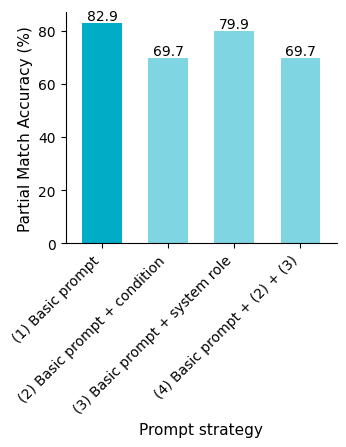

In [12]:
# set figure size
plt.rcParams["figure.figsize"] = [3.5, 3]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create bar plot
ax=plot_res[1].plot(kind='bar', color=cols[3], width=0.6, legend=False)

# add text
for i, v in enumerate(plot_res[1]):
    ax.text(x=i, y=v+0.05, s=f'{v:.1f}', ha='center', va='bottom', fontsize=10)

# x, y label and ticks
ax.set_xlabel('Prompt strategy', fontsize=11)
ax.set_ylabel('Partial Match Accuracy (%)', fontsize=11)
plt.xticks(rotation=45, ha='right')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# highlight first bar
ax.patches[0].set_facecolor(cols[3])

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    if i != 0:  
        patch.set_alpha(0.5) 

# save
save = False
if save == True:
    plt.savefig('analysis/figures_rev/Figure2_accuracyLLMprompt.jpeg', dpi=500, bbox_inches='tight')

plt.show()

#### Figure 2B. Accuracy of LLMs of various sizes across prompt strategies

##### Statistical test on basic vs. combination prompts

In [13]:
new_moalmanac_data=pd.read_csv(f"data/latest_db/moalmanac_fda_core_query__{_VERSION}.csv", index_col=0)
new_synthetic_prompt_groundtruth_dict=load_object(f"data/latest_db/synthetic_query_therapy_pair_dict.pkl")

In [14]:
new_moalmanac_data['standardized_cancer'].nunique()

51

In [15]:
import ast
new_moalmanac_data['biomarker']=new_moalmanac_data['biomarker'].apply(ast.literal_eval)

In [16]:
len({b for b_ls in new_moalmanac_data['biomarker'] for b in b_ls})

156

In [17]:
# Load LLM-only outputs and evaluate
models = ['mist7B', 'mist8B', 'mistnemo', 'mistlarge', 'gptmini', 'gpt4o', 'o4mini']
strategies = [0, 3]

llm_output_dicts = {}
llm_eval_res = {}
partial_acc_dicts = {}

for model in models:
    model_eval = {}
    for strategy in strategies:
        output_key = f"llm_{model.lower()}_res_dict_{strategy}"
        eval_key = f"llm_{model.lower()}_eval_res_{strategy}"
        
        # Load LLM outputs
        if model == 'gpt4o':
            if strategy == 3:
                path = f'output/LLM_res_{model}/stra{strategy}n1temp0.0_res_dict.pkl'
            else: 
                path = f'output/LLM_res_{model}/stra{strategy}n5temp0.0_res_dict.pkl'
        else:
            path = f'output/LLM_res_{model}/stra{strategy}n1temp0.0_res_dict.pkl'
        llm_output_dicts[output_key] = load_object(filename=path)
        
        # Evaluate LLM outputs
        eval_result = calc_eval_metrics(
            llm_output_dicts[output_key]['full output'][0], 
            prev_moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        llm_eval_res[eval_key] = eval_result
        
        # Save each model's results
        model_eval[strategy] = {'partial_match_acc':eval_result['partial_match_acc'], 'avg_partial_match_acc':eval_result['avg_partial_match_acc']}
        
    partial_acc_dicts[f"{model}_partial_acc_dict"] = model_eval

In [18]:
# Create contingency table for mcnemar's test
mcnemar_tables = {}
for model in models:
    mcnemar_tables[f'{model}_partial_table'] = create_mcnemar_table(
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['partial_match_acc']
    )

In [19]:
# Run McNemar and get accuracies
model_labels = dict(zip(models, ['mist_7B', 'mist_8B', 'mistnemo_12B', 'mistlarge_123B', 'gpt4omini', 'gpt4o','o4mini']))

mcnemar_result = {}
accuracy = {}
p_values = {}

for model, label in model_labels.items():
    # Run McNemar's test
    mcnemar_result[f'{model}_mcnemar_res'], _, _ = conduct_mcnemar_test(mcnemar_tables[f'{model}_partial_table'])
    print(print_mcnemar_res(mcnemar_result[f'{model}_mcnemar_res'], alpha=0.05))

    # Get p-values
    p_values[label] = mcnemar_result[f'{model}_mcnemar_res'].pvalue
    
    # Get accuracies
    accuracy[label] = [
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['avg_partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['avg_partial_match_acc']
    ]

Significance: False; Test Statistic: 0.5538461538461539; P-value: 0.4567504024231692
Significance: True; Test Statistic: 4.033333333333333; P-value: 0.04460971802493953
Significance: True; Test Statistic: 23.076923076923077; P-value: 1.5564763744776363e-06
Significance: False; Test Statistic: 5.0; P-value: 0.5810546875
Significance: True; Test Statistic: 8.653846153846153; P-value: 0.0032637169016702335
Significance: True; Test Statistic: 2.0; P-value: 0.03857421875
Significance: True; Test Statistic: 1.0; P-value: 0.00341796875


##### Plot bar graph

In [20]:
all_models_acc=pd.DataFrame(accuracy)
all_models_acc.rename(index={
    0:'(1) Basic prompt',
    1:'(2) Basic prompt + (2) + (3)'
    }, inplace=True
)

all_models_acc=all_models_acc*100
all_models_acc=all_models_acc.transpose()
all_models_acc

,(1) Basic prompt,(2) Basic prompt + (2) + (3)
mist_7B,47.863248,50.854701
mist_8B,57.264957,62.393162
mistnemo_12B,82.905983,69.658120
mistlarge_123B,80.341880,79.059829
gpt4omini,88.034188,81.196581
gpt4o,89.316239,85.897436
o4mini,85.470085,80.769231


In [21]:
def pval_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

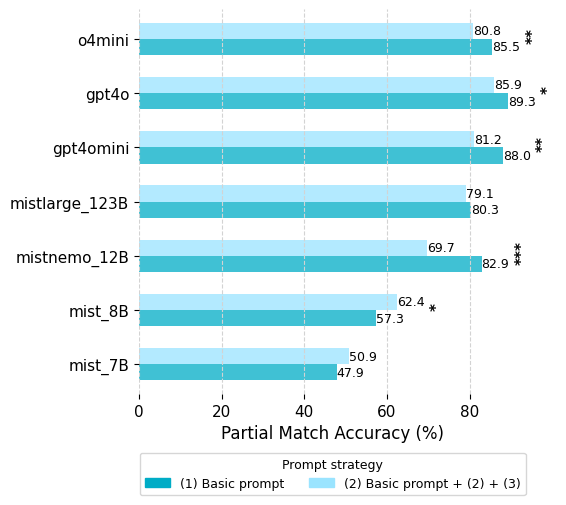

In [22]:
plot_res=all_models_acc

# set figure size
plt.rcParams["figure.figsize"] = [5, 5]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cols[3], cols[25]]))

# create bar plot
ax=plot_res.plot(kind='barh', color=row_colors, width=0.6, legend=False)

# add text
for bar in ax.patches:
    x = bar.get_width() 
    y = bar.get_y() + bar.get_height()/2 
    ax.text(x+0.02, y, f'{x:.1f}', ha='left', va='center', fontsize=9)

# add p-value significance
yticks = np.arange(len(plot_res.index))  
bar_height = ax.patches[0].get_height()
n_bars = plot_res.shape[1] 
bar_offsets = np.linspace(-bar_height/2, bar_height/2, n_bars, endpoint=False) 

for i, (label, pval) in enumerate(p_values.items()):
    if label not in plot_res.index:
        continue
    row_idx = plot_res.index.get_loc(label)

    # get bars for each label
    bar_group = [ax.patches[col * len(plot_res.index) + row_idx] for col in range(plot_res.shape[1])]
    bar1, bar2 = bar_group
    y_pos = yticks[row_idx] + np.mean(bar_offsets[:2]) + bar_height / 2 
    x_pos = max(bar1.get_width(), bar2.get_width()) + 8

    # convert p-value to stars
    sig = pval_to_stars(pval)
    if sig:
        ax.text(x_pos, y_pos, sig,
                ha='left', va='center',
                fontsize=11, fontweight='bold', rotation=90)
    
# x, y label and ticks
ax.set_xlabel('Partial Match Accuracy (%)', fontsize=12)
ax.set_ylabel('')
ax.tick_params(labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.75)

# create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title="Prompt strategy", 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          )
legend.get_frame().set_facecolor('white')

# set background and grid color
ax.set_facecolor('white')
ax.grid(axis='x', linestyle='--', color='lightgray', linewidth=0.8)

# save
save = False
if save == True:
    plt.savefig(f'analysis/figures_rev/Figure2_accuracyPromptLLMbar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

#### Figure 3A. Impact of RAG integration on LLM performance with unstructured and structured database

Earlier DB

In [23]:
BASE_MODEL='gpt4o'
SYNTHETIC_QUERY_v2024=pd.read_csv("data/moa_fda_queries_answers.csv", index_col=0)
SYNTHETIC_TRUE_v2024=load_object("data/synthetic_prompt_groundtruth_dict.pkl")
strategies=['0']
num_iter=5

In [24]:
SYNTHETIC_QUERY_v2024.shape

(234, 50)

In [25]:
LLM_FILEPATH=f'output/LLM_res_{BASE_MODEL}'
UNSTRUC_DENSE10_FILEPATH=f'output/RAG_res_{BASE_MODEL}/unstructured'
STRUC_DENSE10_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured'

_MODE_PATHS = {
    "LLM":{
        "llm": LLM_FILEPATH
    },
    "RAG":{
        "unstructured_dense_k10": UNSTRUC_DENSE10_FILEPATH,
        "structured_dense_k10": STRUC_DENSE10_FILEPATH,
    },
}

evaluator_synthetic_queries_v2024 = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=SYNTHETIC_QUERY_v2024,
    true_dict=SYNTHETIC_TRUE_v2024,
    mode_paths=_MODE_PATHS,
    num_iter=num_iter
)

evaluator_synthetic_queries_v2024.run()
average = evaluator_synthetic_queries_v2024.average()
average

{'LLM': {'llm': {'exact': {'0': 0.6213675213675214},
   'partial': {'0': 0.8940170940170941},
   'precision': {'0': 0.4379059829059824},
   'recall': {'0': 0.7058404558404553},
   'f1': {'0': 0.5087986087986094},
   'specificity': {'0': 0.9905922100788722}}},
 'RAG': {'unstructured_dense_k10': {'exact': {'0': 0.7188034188034188},
   'partial': {'0': 0.9487179487179487},
   'precision': {'0': 0.3966912629249232},
   'recall': {'0': 0.7598290598290596},
   'f1': {'0': 0.4612553761263777},
   'specificity': {'0': 0.9754444600423616}},
  'structured_dense_k10': {'exact': {'0': 0.9452991452991453},
   'partial': {'0': 0.9572649572649572},
   'precision': {'0': 0.7969210419210417},
   'recall': {'0': 0.947008547008547},
   'f1': {'0': 0.8427215804138882},
   'specificity': {'0': 0.9967776185580156}}}}

Latest DB

In [26]:
BASE_MODEL='gpt4o_default'
SYNTHETIC_QUERY_v2025=pd.read_csv(f"data/latest_db/moalmanac_fda_core_query__{_VERSION}.csv", index_col=0)
SYNTHETIC_TRUE_v2025=load_object("data/latest_db/synthetic_query_therapy_pair_dict.pkl")
strategies=['0']
num_iter=5

In [27]:
SYNTHETIC_QUERY_v2025.shape

(651, 8)

In [28]:
LLM_FILEPATH=f'output/LLM_res_{BASE_MODEL}/db_v202510'
UNSTRUC_DENSE10_FILEPATH=f'output/RAG_res_{BASE_MODEL}/unstructured_synthetic_db_v202510_dense_numvec10'
STRUC_DENSE10_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_synthetic_db_v202510_dense_numvec10'
STRUC_DENSE25_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_synthetic_db_v202510_dense_numvec25'

_MODE_PATHS = {
    "LLM":{
        "llm": LLM_FILEPATH
    },
    "RAG":{
        "unstructured_dense_k10": UNSTRUC_DENSE10_FILEPATH,
        "structured_dense_k10": STRUC_DENSE10_FILEPATH,
        "structured_dense_k25": STRUC_DENSE25_FILEPATH,
    },
}

evaluator_synthetic_queries_v2025 = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=SYNTHETIC_QUERY_v2025,
    true_dict=SYNTHETIC_TRUE_v2025,
    mode_paths=_MODE_PATHS,
    num_iter=num_iter
)

evaluator_synthetic_queries_v2025.run()
average = evaluator_synthetic_queries_v2025.average()
average

{'LLM': {'llm': {'exact': {'0': 0.2033794162826421},
   'partial': {'0': 0.6860215053763441},
   'precision': {'0': 0.4231541218637993},
   'recall': {'0': 0.2704805793285056},
   'f1': {'0': 0.30619388974227685},
   'specificity': {'0': 0.9967770716743806}}},
 'RAG': {'unstructured_dense_k10': {'exact': {'0': 0.5081413210445469},
   'partial': {'0': 0.8795698924731182},
   'precision': {'0': 0.4719070396899469},
   'recall': {'0': 0.6181500987491774},
   'f1': {'0': 0.46747090418013065},
   'specificity': {'0': 0.9829268996773385}},
  'structured_dense_k10': {'exact': {'0': 0.5941628264208909},
   'partial': {'0': 0.946236559139785},
   'precision': {'0': 0.8943782459220246},
   'recall': {'0': 0.7641386877331585},
   'f1': {'0': 0.7878830426930052},
   'specificity': {'0': 0.9981251634653576}},
  'structured_dense_k25': {'exact': {'0': 0.6786482334869431},
   'partial': {'0': 0.9895545314900154},
   'precision': {'0': 0.9280162165876453},
   'recall': {'0': 0.8224560505205674},
   'f

In [29]:
models_v2024 = {
    'unstructured_v2024': ('RAG', 'unstructured_dense_k10'),
    'structured_top10_v2024': ('RAG', 'structured_dense_k10'),
    'llm_v2024': ('LLM', 'llm')
}
models_v2025 = {
    'unstructured_v2025': ('RAG', 'unstructured_dense_k10'),
    'structured_top10_v2025': ('RAG', 'structured_dense_k10'),
    'structured_top25_v2025': ('RAG', 'structured_dense_k25'),
    'llm_v2025': ('LLM', 'llm')
}
evaluators = {
    'v2024': evaluator_synthetic_queries_v2024,
    'v2025': evaluator_synthetic_queries_v2025
}
metrics = ['avg_exact_match_acc', 'avg_partial_match_acc', 
           'avg_precision', 'avg_recall', 'avg_f1', 'avg_specificity']
all_results_ls = {}
metric_dicts = {m: {} for m in metrics}
for year, evaluator in evaluators.items():
    for system in evaluator.evals: 
        for key in evaluator.evals[system]:  
            model_name = f"{key}_{year}"
            all_results_ls[model_name] = { 'results': [] }
            for m in metrics:
                metric_dicts[m][model_name] = []
            for i in range(5):
                result = evaluator.evals[system][key]['0'][i]
                all_results_ls[model_name]['results'].append(result)
                for m in metrics:
                    metric_dicts[m][model_name].append(result[m])

In [30]:
all_avg_exact_match_acc={mode: np.mean([run['avg_exact_match_acc'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}
all_avg_partial_match_acc={mode: np.mean([run['avg_partial_match_acc'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}
all_avg_precision={mode: np.mean([run['avg_partial_match_acc'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}
all_avg_recall={mode: np.mean([run['avg_recall'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}
all_avg_f1={mode: np.mean([run['avg_f1'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}
all_avg_specificity={mode: np.mean([run['avg_specificity'] for run in all_results_ls[mode]['results']]) for mode in all_results_ls}

print(f"{all_avg_exact_match_acc=}")
print(f"{all_avg_partial_match_acc=}")
print(f"{all_avg_precision=}")
print(f"{all_avg_recall=}")
print(f"{all_avg_f1=}")
print(f"{all_avg_specificity=}")

all_avg_exact_match_acc={'llm_v2024': 0.6213675213675214, 'unstructured_dense_k10_v2024': 0.7188034188034188, 'structured_dense_k10_v2024': 0.9452991452991453, 'llm_v2025': 0.2033794162826421, 'unstructured_dense_k10_v2025': 0.5081413210445469, 'structured_dense_k10_v2025': 0.5941628264208909, 'structured_dense_k25_v2025': 0.6786482334869431}
all_avg_partial_match_acc={'llm_v2024': 0.8940170940170941, 'unstructured_dense_k10_v2024': 0.9487179487179487, 'structured_dense_k10_v2024': 0.9572649572649572, 'llm_v2025': 0.6860215053763441, 'unstructured_dense_k10_v2025': 0.8795698924731182, 'structured_dense_k10_v2025': 0.946236559139785, 'structured_dense_k25_v2025': 0.9895545314900154}
all_avg_precision={'llm_v2024': 0.8940170940170941, 'unstructured_dense_k10_v2024': 0.9487179487179487, 'structured_dense_k10_v2024': 0.9572649572649572, 'llm_v2025': 0.6860215053763441, 'unstructured_dense_k10_v2025': 0.8795698924731182, 'structured_dense_k10_v2025': 0.946236559139785, 'structured_dense_k25

In [31]:
perc_increase(old=np.mean(all_avg_partial_match_acc['structured_dense_k10_v2025']), 
              new=np.mean(all_avg_partial_match_acc['structured_dense_k25_v2025']))

4.577922077922074

In [32]:
perc_increase(old=np.mean(all_avg_exact_match_acc['structured_dense_k10_v2025']), 
              new=np.mean(all_avg_exact_match_acc['structured_dense_k25_v2025']))

14.219234746639092

##### Run statistical test to compare performances

RAG-LLM unstructured vs. LLM-only - across five iterations - mcnemar's test

Compare:

1) RAG-LLM unstructured vs. LLM-only (based on old DB)
2) RAG-LLM unstructured vs. LLM-only (based on new DB)

In [33]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='unstructured_dense_k10_v2024'
model_B='llm_v2024'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A]['results'][i]['exact_match_acc'],
        all_results_ls[model_B]['results'][i]['exact_match_acc'],
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A]['results'][i]['partial_match_acc'],
        all_results_ls[model_B]['results'][i]['partial_match_acc'],
        )
                            )

In [34]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
cohens_g_runs=[]
odds_ratio_runs=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc, exact_effect = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc, partial_effect = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # store per-run effect sizes
    cohens_g_runs.append([exact_effect['cohens_g'], partial_effect['cohens_g']])
    odds_ratio_runs.append([exact_effect['odds_ratio'], partial_effect['odds_ratio']])
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc, pooled_exact_effect = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc, pooled_partial_effect = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)} (Effect size={pooled_exact_effect["cohens_g"]:.3f})')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)} (Effect size={pooled_partial_effect["cohens_g"]:.3f})')

all_mcnemar_results = {
    f'{model_A}_vs_{model_B}': {'exact': pooled_exact_result, 'partial': pooled_partial_result}
    }

unstructured_dense_k10_v2024_vs_llm_v2024:
Exact: Significance: True; Test Statistic: 48.73664122137404; P-value: 2.927457607373714e-12 (Effect size=0.435)
Partial: Significance: True; Test Statistic: 21.570652173913043; P-value: 3.4103048786057504e-06 (Effect size=0.348)


RAG-LLM structured vs. RAG-LLM unstructured - across five iterations - mcnemar's test

In [35]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='structured_dense_k10_v2024'
model_B='unstructured_dense_k10_v2024'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A]['results'][i]['exact_match_acc'],
        all_results_ls[model_B]['results'][i]['exact_match_acc'],
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A]['results'][i]['partial_match_acc'],
        all_results_ls[model_B]['results'][i]['partial_match_acc'],
        )
                            )

In [36]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
cohens_g_runs=[]
odds_ratio_runs=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc, exact_effect = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc, partial_effect = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # store per-run effect sizes
    cohens_g_runs.append([exact_effect['cohens_g'], partial_effect['cohens_g']])
    odds_ratio_runs.append([exact_effect['odds_ratio'], partial_effect['odds_ratio']])
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc, pooled_exact_effect = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc, pooled_partial_effect = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)} (Effect size={pooled_exact_effect["cohens_g"]:.3f})')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)} (Effect size={pooled_partial_effect["cohens_g"]:.3f})')

all_mcnemar_results[f'{model_A}_vs_{model_B}']={'exact': pooled_exact_result, 'partial': pooled_partial_result}

structured_dense_k10_v2024_vs_unstructured_dense_k10_v2024:
Exact: Significance: True; Test Statistic: 190.94794520547944; P-value: 1.9743208102812907e-43 (Effect size=0.726)
Partial: Significance: False; Test Statistic: 0.7363636363636363; P-value: 0.3908282308519907 (Effect size=0.091)


##### Adjust p-values from all comparisons

In [38]:
all_pvalues=[]
for comparison, output in all_mcnemar_results.items():
    all_pvalues.append(output['exact'].pvalue)
    all_pvalues.append(output['partial'].pvalue)
_, p_corrected, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')
p_corrected

array([5.85491521e-12, 4.54707317e-06, 7.89728324e-43, 3.90828231e-01])

In [39]:
print(f"Raw: {all_mcnemar_results['unstructured_dense_k10_v2024_vs_llm_v2024']['exact'].pvalue}, {all_mcnemar_results['unstructured_dense_k10_v2024_vs_llm_v2024']['partial'].pvalue}")
print(f'Adjusted: {p_corrected[0:2]}')

Raw: 2.927457607373714e-12, 3.4103048786057504e-06
Adjusted: [5.85491521e-12 4.54707317e-06]


In [40]:
print(f"Raw: {all_mcnemar_results['structured_dense_k10_v2024_vs_unstructured_dense_k10_v2024']['exact'].pvalue}, {all_mcnemar_results['structured_dense_k10_v2024_vs_unstructured_dense_k10_v2024']['partial'].pvalue}")
print(f'Adjusted: {p_corrected[2:4]}')

Raw: 1.9743208102812907e-43, 0.3908282308519907
Adjusted: [7.89728324e-43 3.90828231e-01]


##### Plot bar graph

Using acc results from all five iterations

In [41]:
all_results_ls.keys()

dict_keys(['llm_v2024', 'unstructured_dense_k10_v2024', 'structured_dense_k10_v2024', 'llm_v2025', 'unstructured_dense_k10_v2025', 'structured_dense_k10_v2025', 'structured_dense_k25_v2025'])

In [42]:
# compute means and standard deviations
means = {
    'LLM-only (DB v2024)': 
        [np.mean([all_results_ls['llm_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['llm_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Unstructured RAG-LLM (DB v2024)': 
        [np.mean([all_results_ls['unstructured_dense_k10_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['unstructured_dense_k10_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Structured RAG-LLM (DB v2024)': 
        [np.mean([all_results_ls['structured_dense_k10_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['structured_dense_k10_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'LLM-only (DB v2025)': 
        [np.mean([all_results_ls['llm_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['llm_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Unstructured RAG-LLM (DB v2025)': 
        [np.mean([all_results_ls['unstructured_dense_k10_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['unstructured_dense_k10_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Structured RAG-LLM (DB v2025)': 
        [np.mean([all_results_ls['structured_dense_k10_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.mean([all_results_ls['structured_dense_k10_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100]
        }


stds = {
    'LLM-only (DB v2024)': 
        [np.std([all_results_ls['llm_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['llm_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Unstructured RAG-LLM (DB v2024)': 
        [np.std([all_results_ls['unstructured_dense_k10_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['unstructured_dense_k10_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Structured RAG-LLM (DB v2024)': 
        [np.std([all_results_ls['structured_dense_k10_v2024']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['structured_dense_k10_v2024']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'LLM-only (DB v2025)': 
        [np.std([all_results_ls['llm_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['llm_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Unstructured RAG-LLM (DB v2025)': 
        [np.std([all_results_ls['unstructured_dense_k10_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['unstructured_dense_k10_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100],
    'Structured RAG-LLM (DB v2025)': 
        [np.std([all_results_ls['structured_dense_k10_v2025']['results'][i]['avg_exact_match_acc'] for i in range(5)]) * 100, 
         np.std([all_results_ls['structured_dense_k10_v2025']['results'][i]['avg_partial_match_acc'] for i in range(5)]) * 100]
        }

# convert to dataframe
plot_res = pd.DataFrame(means, index=['Exact match accuracy','Partial match accuracy'])

# Convert stds to DataFrame for error bars
error_bars = pd.DataFrame(stds, index=['Exact match accuracy','Partial match accuracy'])

plot_res

,LLM-only (DB v2024),Unstructured RAG-LLM (DB v2024),Structured RAG-LLM (DB v2024),LLM-only (DB v2025),Unstructured RAG-LLM (DB v2025),Structured RAG-LLM (DB v2025)
Exact match accuracy,62.136752,71.880342,94.529915,20.337942,50.814132,59.416283
Partial match accuracy,89.401709,94.871795,95.726496,68.602151,87.956989,94.623656


In [43]:
plot_long = plot_res.reset_index().melt(
    id_vars='index', 
    var_name='Model', 
    value_name='Accuracy'
).rename(columns={'index': 'Metric'})
plot_long['DB_version'] = plot_long['Model'].str.extract(r'\(DB (v\d{4})\)')
plot_long['Model_short'] = plot_long['Model'].str.replace(r' \(DB v\d{4}\)', '', regex=True)

error_long = error_bars.reset_index().melt(
    id_vars='index',
    var_name='Model',
    value_name='Std'
).rename(columns={'index': 'Metric'})

In [44]:
plot_df=pd.concat([plot_long, error_long['Std']], axis=1)

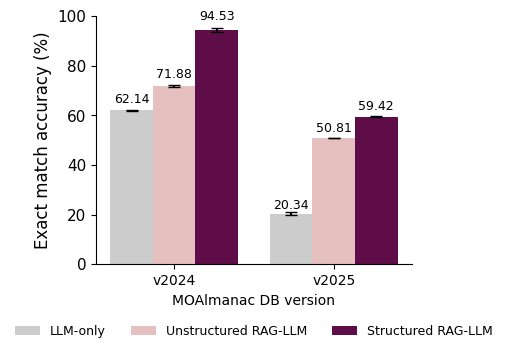

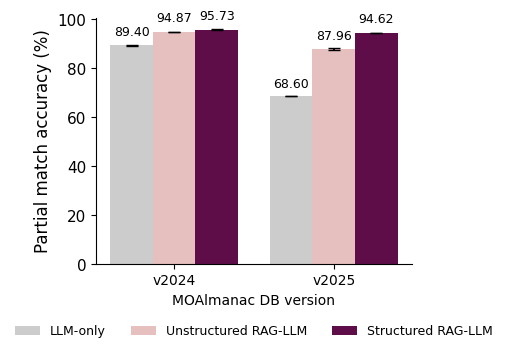

In [45]:
plt.rcParams["figure.figsize"] = [4.7, 3.7]

metrics = ['Exact match accuracy', 'Partial match accuracy']
metrics_file_label = {'Exact match accuracy':'exact', 'Partial match accuracy':'partial'}

for m in metrics:
    ax=sns.barplot(
        data=plot_df[plot_df.Metric==m],
        x='DB_version',
        y='Accuracy',
        hue='Model_short',
        palette=['0.8', cols[23], cols[6]],
        capsize=0.05,
        errorbar=None
    )

    for i, p in enumerate(ax.patches):
        val = p.get_height()
        std = plot_df[plot_df.Metric==m]['Std'].values[i]
        ax.errorbar(
            p.get_x() + p.get_width()/2, val,
            yerr=std,
            fmt='none',
            ecolor='black',
            capsize=4
        )
        
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}', 
            (p.get_x() + p.get_width()/2., p.get_height()*1.03), 
            ha='center', va='bottom', fontsize=9
        )

    ax.set_ylabel(f'{m} (%)', fontsize=12)
    ax.set_xlabel('MOAlmanac DB version')
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=10)
    sns.despine(top=True, right=True)
    plt.legend(title='', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3, frameon=False, fontsize=9)
    plt.tight_layout()

    # save
    save = False
    if save == True:
        plt.savefig(f'analysis/figures_rev/Figure3_{metrics_file_label[m]}AccuracyRAGLLMbar.jpeg', dpi=500, bbox_inches='tight')

    plt.show()

#### Figure 3B. Impact on other evaluation metrics: precision, recall, f1, specificity

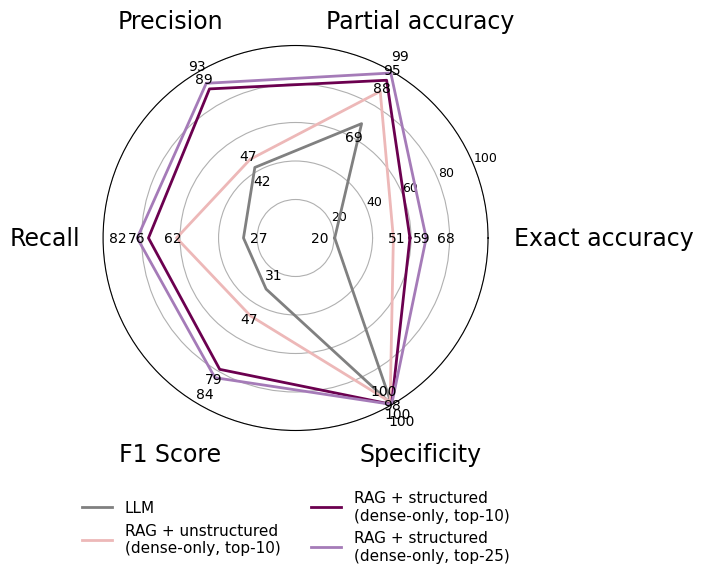

In [46]:
cols=sns.color_palette(cc.glasbey)
eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))
synthetic_queries_average_v2025=evaluator_synthetic_queries_v2025.average()
plot_results = {
    'LLM': {k: v['0']*100 for k, v in synthetic_queries_average_v2025['LLM']['llm'].items()},
    'RAG + unstructured\n(dense-only, top-10)': {k: v['0']*100 for k, v in synthetic_queries_average_v2025['RAG']['unstructured_dense_k10'].items()},
    'RAG + structured\n(dense-only, top-10)': {k: v['0']*100 for k, v in synthetic_queries_average_v2025['RAG']['structured_dense_k10'].items()},
    'RAG + structured\n(dense-only, top-25)': {k: v['0']*100 for k, v in synthetic_queries_average_v2025['RAG']['structured_dense_k25'].items()},
}
plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title=None,
    colors=['grey',cols[23],cols[6],cols[27]],
    offsets=[-0.08, 0.02, 0.06, 0.1],
    # save_path='analysis/figures_rev/Figure3_ragllmPerformance_radar.jpeg'
    )

In [47]:
for k in synthetic_queries_average_v2025['RAG']['structured_dense_k10'].keys():
    print(k, 
          synthetic_queries_average_v2025['RAG']['unstructured_dense_k10'][k]['0'],
          synthetic_queries_average_v2025['RAG']['structured_dense_k10'][k]['0'],
          perc_increase(new=synthetic_queries_average_v2025['RAG']['structured_dense_k10'][k]['0'],
                        old=synthetic_queries_average_v2025['RAG']['unstructured_dense_k10'][k]['0'])
                        )

exact 0.5081413210445469 0.5941628264208909 16.92865779927447
partial 0.8795698924731182 0.946236559139785 7.579462102689498
precision 0.4719070396899469 0.8943782459220246 89.52424327249928
recall 0.6181500987491774 0.7641386877331585 23.61701296811051
f1 0.46747090418013065 0.7878830426930052 68.5416216598178
specificity 0.9829268996773385 0.9981251634653576 1.5462252374015009


In [48]:
# Compare statistically
from scipy.stats import wilcoxon

statss=[]
pvals=[]
for k in synthetic_queries_average_v2025['RAG']['structured_dense_k10'].keys():
    stats, p = wilcoxon(evaluator_synthetic_queries_v2025.results['RAG']['structured_dense_k10'][k]['0'],
                   evaluator_synthetic_queries_v2025.results['RAG']['unstructured_dense_k10'][k]['0'],
                   alternative='greater')
    statss.append(stats)
    pvals.append(p)

_, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh')

print(statss)
print(pvals_adj)

[15.0, 15.0, 15.0, 15.0, 15.0, 15.0]
[0.03125 0.03125 0.03125 0.03125 0.03125 0.03125]


#### Figure 3C. Accuracy of RAG-LLM across therapies, diseases and genomic alterations

Get exact match accuracies from the first iteration

In [49]:
with open(f"data/latest_db/fda_statements__{_VERSION}.json", "r") as f:
    fda_statements=json.load(f)
cancer_ids=[stmt['proposition']['conditionQualifier']['primaryCoding']['id'] for stmt in fda_statements]

In [50]:
# Create df for plotting
plot_df = new_moalmanac_data
plot_df['cancer_id'] = cancer_ids
plot_df['LLM_only'] = evaluator_synthetic_queries_v2025.evals['LLM']['llm']['0'][0]['exact_match_acc']
plot_df['RAGLLM_struc_res_k10'] = evaluator_synthetic_queries_v2025.evals['RAG']['structured_dense_k10']['0'][0]['exact_match_acc']
plot_df['RAGLLM_struc_res_k25'] = evaluator_synthetic_queries_v2025.evals['RAG']['structured_dense_k25']['0'][0]['exact_match_acc']
plot_df['RAGLLM_unstruc_res_k10'] = evaluator_synthetic_queries_v2025.evals['RAG']['unstructured_dense_k10']['0'][0]['exact_match_acc']
plot_df

,statement_id,standardized_cancer,raw_cancer,modified_standardized_cancer,biomarker,therapy,prompt,answer,cancer_id,LLM_only,RAGLLM_struc_res_k10,RAGLLM_struc_res_k25,RAGLLM_unstruc_res_k10
0,0,invasive breast carcinoma,early breast cancer,early invasive breast carcinoma,"[ER positive, HER2-negative]","['Tamoxifen', 'Abemaciclib']",if a patient with early invasive breast carcin...,if a patient with early invasive breast carcin...,oncotree:BRCA,False,False,True,False
1,1,invasive breast carcinoma,early breast cancer,early invasive breast carcinoma,"[PR positive, HER2-negative]","['Tamoxifen', 'Abemaciclib']",if a patient with early invasive breast carcin...,if a patient with early invasive breast carcin...,oncotree:BRCA,False,False,False,False
2,2,invasive breast carcinoma,early breast cancer,early invasive breast carcinoma,"[PR positive, ER positive, HER2-negative]","['Tamoxifen', 'Abemaciclib']",if a patient with early invasive breast carcin...,if a patient with early invasive breast carcin...,oncotree:BRCA,False,False,False,False
3,3,invasive breast carcinoma,advanced or metastatic breast cancer,advanced or metastatic invasive breast carcinoma,"[ER positive, HER2-negative]","['Anastrozole', 'Abemaciclib']",if a patient with advanced or metastatic invas...,if a patient with advanced or metastatic invas...,oncotree:BRCA,False,False,False,False
4,4,invasive breast carcinoma,advanced or metastatic breast cancer,advanced or metastatic invasive breast carcinoma,"[PR positive, HER2-negative]","['Anastrozole', 'Abemaciclib']",if a patient with advanced or metastatic invas...,if a patient with advanced or metastatic invas...,oncotree:BRCA,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,1152,acute myeloid leukemia,newly diagnosed acute myeloid leukemia (aml),acute myeloid leukemia,[FLT3-ITD],"['Cytarabine', 'Quizartinib', 'Daunorubicin']",if a patient with acute myeloid leukemia cance...,if a patient with acute myeloid leukemia cance...,oncotree:AML,False,False,False,False
647,1153,acute myeloid leukemia,newly diagnosed acute myeloid leukemia (aml),acute myeloid leukemia,[FLT3-ITD],"['Cytarabine', 'Quizartinib', 'Idarubicin']",if a patient with acute myeloid leukemia cance...,if a patient with acute myeloid leukemia cance...,oncotree:AML,False,False,False,False
648,1154,melanoma,melanoma,melanoma,[BRAF p.V600E],"['Trametinib', 'Dabrafenib']",if a patient with melanoma cancer has braf p.v...,if a patient with melanoma cancer has braf p.v...,oncotree:MEL,False,True,True,False
649,1155,melanoma,melanoma,melanoma,[BRAF p.V600K],"['Trametinib', 'Dabrafenib']",if a patient with melanoma cancer has braf p.v...,if a patient with melanoma cancer has braf p.v...,oncotree:MEL,False,True,True,False


Accuracy across cancer types

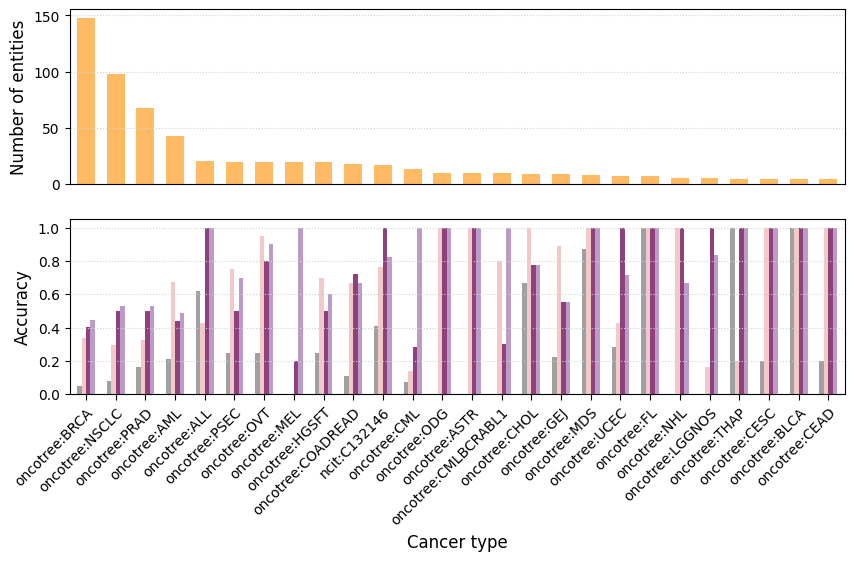

In [51]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
res_columns = ['LLM_only', 'RAGLLM_unstruc_res_k10', 'RAGLLM_struc_res_k10', 'RAGLLM_struc_res_k25']
for col in res_columns:
    df = pd.crosstab(plot_df['cancer_id'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['cancer_id']), orient="index", columns=["Number of relationships"])
df_all=df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[:-1], ['grey',cols[23],cols[6],cols[27]]))
num_rel_color = cols[7]

# create bar plot
df_all=df_all[df_all['Number of relationships'] >= 5]
df_all[res_columns].plot(kind='bar', color=struc_unstruc_colors, 
                                                        width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Cancer type', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=4)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor')

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    ax.set_facecolor('white')
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')  

# Save plot
save = False
if save == True:
    plt.savefig(f'analysis/figures_rev/Figure3_cancerAcc_bar.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [52]:
cancer_abb_df=plot_df.drop_duplicates(['cancer_id','standardized_cancer'])
cancer_abb_df[cancer_abb_df['cancer_id'].isin(df_all.index)][['cancer_id','standardized_cancer']].to_csv("analysis/figures_rev/Figure3_cancerType_abbrev.csv", index=False)

In [53]:
# calculate percentage increase from unstruc to struc k10
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res_k10'], 
                                                                 new=row['RAGLLM_struc_res_k10']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]\
    .merge(plot_df[['standardized_cancer','cancer_id']], 
           left_index=True, right_on='cancer_id', how='inner')\
               .drop_duplicates()

,LLM_only,RAGLLM_unstruc_res_k10,RAGLLM_struc_res_k10,RAGLLM_struc_res_k25,Number of relationships,perc_increase,standardized_cancer,cancer_id
102,0.000000,0.166667,1.000000,0.833333,6,500.000000,"low-grade glioma, nos",oncotree:LGGNOS
100,1.000000,0.200000,1.000000,1.000000,5,400.000000,anaplastic thyroid cancer,oncotree:THAP
48,0.619048,0.428571,1.000000,1.000000,21,133.333333,acute lymphoid leukemia,oncotree:ALL
113,0.285714,0.428571,1.000000,0.714286,7,133.333333,endometrial carcinoma,oncotree:UCEC
32,0.071429,0.142857,0.285714,1.000000,14,100.000000,chronic myelogenous leukemia,oncotree:CML
19,0.081633,0.295918,0.500000,0.530612,98,68.965517,non-small cell lung cancer,oncotree:NSCLC
15,0.161765,0.323529,0.500000,0.529412,68,54.545455,prostate adenocarcinoma,oncotree:PRAD
101,0.411765,0.764706,1.000000,0.823529,17,30.769231,any solid tumor,ncit:C132146


Accuracy across therapy types

In [54]:
from utils.flatten_statement import flatten_statements

therapy_strategies=[]
for stmt in fda_statements:
    _, stmt_row = flatten_statements(stmt)
    strategies = {s for s in stmt_row['therapy_strategy']}
    therapy_strategy = ' + '.join([s for s in strategies])
    therapy_strategies.append(therapy_strategy.lower())
len(therapy_strategies)

651

In [55]:
# clean therapy strategy names
plot_df['therapy_strategy']=therapy_strategies
plot_df['therapy_strategy_2']=plot_df['therapy_strategy'].replace(r'inhibition|targets|signaling','', regex=True).str.replace(r'\s+', ' ', regex=True).replace(r'chemotherapy|Chemotherapy','chemo', regex=True).str.strip()

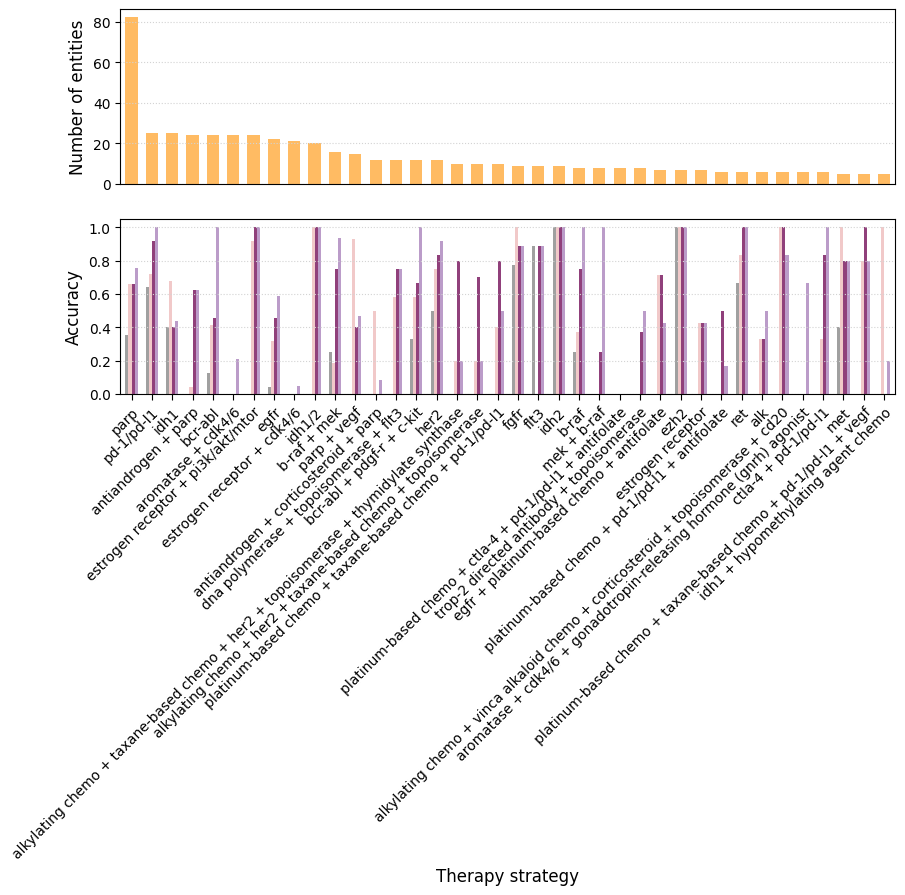

In [56]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
res_columns = ['LLM_only','RAGLLM_unstruc_res_k10', 'RAGLLM_struc_res_k10', 'RAGLLM_struc_res_k25']
for col in res_columns:
    df = pd.crosstab(plot_df['therapy_strategy_2'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['therapy_strategy_2']), orient="index", columns=["Number of relationships"])
df_all = df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[:-1], ["grey",cols[23],cols[6],cols[27]]))
num_rel_color = cols[7]

# create bar plot
df_all=df_all[df_all['Number of relationships'] >= 5]
df_all[res_columns].plot(kind='bar', color=struc_unstruc_colors, width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Therapy strategy', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=4)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor') 

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    # change background color
    ax.set_facecolor('white')
    # change grid color
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')

# save plot
save = False
if save == True:
    plt.savefig(f'analysis/figures_rev/Figure3_therapyAcc_bar.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [57]:
cancer_abb_df=plot_df.drop_duplicates(['therapy_strategy_2','therapy_strategy'])
cancer_abb_df[cancer_abb_df['therapy_strategy_2'].isin(df_all.index)][['therapy_strategy_2','therapy_strategy']].to_csv("analysis/figures_rev/Figure3_therapyStrat_abbrev.csv", index=False)

In [58]:
# calculate percentage increase dataframe
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res_k10'], 
                                                                 new=row['RAGLLM_struc_res_k10']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]

,LLM_only,RAGLLM_unstruc_res_k10,RAGLLM_struc_res_k10,RAGLLM_struc_res_k25,Number of relationships,perc_increase
antiandrogen + parp,0.000000,0.041667,0.625000,0.625000,24,1400.000000
alkylating chemo + taxane-based chemo + her2 + topoisomerase + thymidylate synthase,0.000000,0.200000,0.800000,0.200000,10,300.000000
b-raf + mek,0.250000,0.187500,0.750000,0.937500,16,300.000000
alkylating chemo + her2 + taxane-based chemo + topoisomerase,0.000000,0.200000,0.700000,0.200000,10,250.000000
ctla-4 + pd-1/pd-l1,0.000000,0.333333,0.833333,1.000000,6,150.000000
platinum-based chemo + taxane-based chemo + pd-1/pd-l1,0.000000,0.400000,0.800000,0.500000,10,100.000000
b-raf,0.250000,0.375000,0.750000,1.000000,8,100.000000
egfr,0.045455,0.318182,0.454545,0.590909,22,42.857143


In [59]:
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :].index

Index(['antiandrogen + parp',
       'alkylating chemo + taxane-based chemo + her2 + topoisomerase + thymidylate synthase',
       'b-raf + mek',
       'alkylating chemo + her2 + taxane-based chemo + topoisomerase',
       'ctla-4 + pd-1/pd-l1',
       'platinum-based chemo + taxane-based chemo + pd-1/pd-l1', 'b-raf',
       'egfr'],
      dtype='object')

Accuracy from a subgroup of questions

In [62]:
def avg_acc_over_questions(results_dict, question_ind):
    
    exact_acc = np.mean([
        np.mean([results_dict[run]['exact_match_acc'][q] for q in question_ind])
        for run in range(len(results_dict))
        ])
    
    partial_acc = np.mean([
        np.mean([results_dict[run]['partial_match_acc'][q] for q in question_ind])
        for run in range(len(results_dict))
        ])
    
    return f"avg exact acc={exact_acc*100:.2f}; avg partial acc={partial_acc*100:.2f}"

In [63]:
ar_parp_ind = [i for i in range(len(plot_df)) if plot_df.loc[i, 'therapy_strategy_2'] == 'antiandrogen + parp']

print(f"LLM-only: {avg_acc_over_questions(evaluator_synthetic_queries_v2025.evals['LLM']['llm']['0'], ar_parp_ind)}")
print(f"Unstructured: {avg_acc_over_questions(evaluator_synthetic_queries_v2025.evals['RAG']['unstructured_dense_k10']['0'], ar_parp_ind)}")
print(f"Structured: {avg_acc_over_questions(evaluator_synthetic_queries_v2025.evals['RAG']['structured_dense_k10']['0'], ar_parp_ind)}")

LLM-only: avg exact acc=0.00; avg partial acc=57.50
Unstructured: avg exact acc=4.17; avg partial acc=87.50
Structured: avg exact acc=63.33; avg partial acc=100.00


#### Figure 4A-B. RAG-LLM performance on real-world questions

In [65]:
BASE_MODEL = 'gpt4o_default'
STRATEGIES=['5']
NUM_ITER=5

REAL_QUERY_RAW=pd.read_csv('data/real_world_db/updated_real_world_queries_answers__v2.csv')
REAL_QUERY_VAL=pd.read_csv('data/real_world_db/real_world_validation__v2.csv', index_col=0)
REAL_QUERY_TEST=pd.read_csv('data/real_world_db/real_world_test__v2.csv', index_col=0)
REAL_QUERY_TRUE=load_object('data/real_world_db/real_world_query_fdatherapy_pair_dict.pkl')

VAL_LLM_FILEPATH=f'output/LLM_res_{BASE_MODEL}/realworld_val_v2'
VAL_RAG_STRUC_DENSE_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_realworld_val_v2_db_v202510_dense'
VAL_RAG_STRUC_HYBRID_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_realworld_val_v2_db_v202510_hybrid'

TEST_LLM_FILEPATH=f'output/LLM_res_{BASE_MODEL}/realworld_test_v2'
TEST_RAG_STRUC_DENSE_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_realworld_test_v2_db_v202510_dense'
TEST_RAG_STRUC_HYBRID_FILEPATH=f'output/RAG_res_{BASE_MODEL}/structured_realworld_test_v2_db_v202510_hybrid'

In [66]:
VAL_MODE_PATHS = {
    "LLM":{
        "default": VAL_LLM_FILEPATH
    },
    "RAG":{
        "dense": VAL_RAG_STRUC_DENSE_FILEPATH,
        "hybrid": VAL_RAG_STRUC_HYBRID_FILEPATH    
    },
}

evaluator_real_val_queries = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=STRATEGIES,
    metrics=METRICS,
    query=REAL_QUERY_VAL,
    true_dict=REAL_QUERY_TRUE,
    mode_paths=VAL_MODE_PATHS,
    num_iter=NUM_ITER
)

evaluator_real_val_queries.run()
real_val_queries_average = evaluator_real_val_queries.average()
real_val_queries_results = evaluator_real_val_queries.results
real_val_queries_average

{'LLM': {'default': {'exact': {'5': 0.5714285714285714},
   'partial': {'5': 0.8095238095238095},
   'precision': {'5': 0.7326666666666667},
   'recall': {'5': 0.545},
   'f1': {'5': 0.5952380952380953},
   'specificity': {'5': 0.9978801986343886}}},
 'RAG': {'dense': {'exact': {'5': 0.7142857142857143},
   'partial': {'5': 0.8571428571428571},
   'precision': {'5': 0.784},
   'recall': {'5': 0.6716666666666666},
   'f1': {'5': 0.7017777777777778},
   'specificity': {'5': 0.9995428571428573}},
  'hybrid': {'exact': {'5': 0.8285714285714285},
   'partial': {'5': 0.9238095238095237},
   'precision': {'5': 0.8933333333333333},
   'recall': {'5': 0.7916666666666667},
   'f1': {'5': 0.8163636363636362},
   'specificity': {'5': 0.9997714285714286}}}}

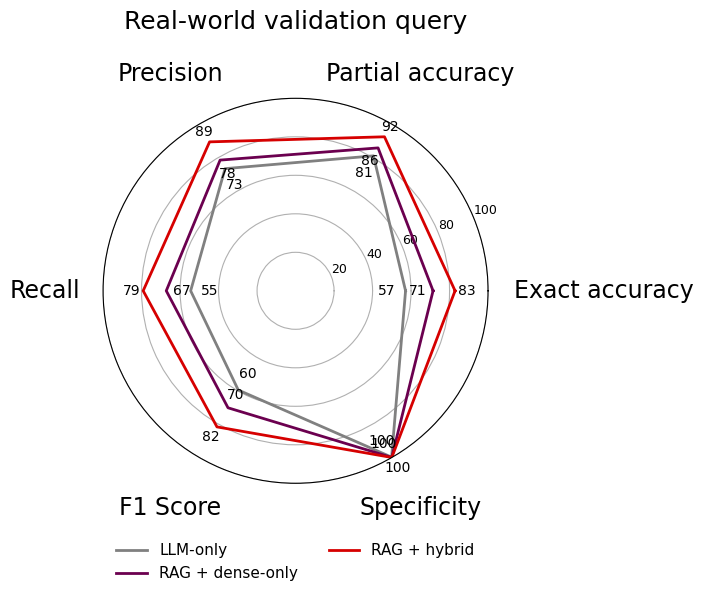

In [67]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'LLM-only': {k: v['5']*100 for k, v in real_val_queries_average['LLM']['default'].items()},
    'RAG + dense-only': {k: v['5']*100 for k, v in real_val_queries_average['RAG']['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in real_val_queries_average['RAG']['hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title="Real-world validation query",
    colors=['grey',cols[6],cols[0]],
    offsets=[-0.1,-0.08, 0.06],
    # save_path="analysis/figures_rev/Figure4_real_world_validation_query_radar_chart.jpeg"
    )

In [68]:
for m in METRICS.keys():
    m_increase = perc_increase(
        old=real_val_queries_average['RAG']['dense'][m]['5'], 
        new=real_val_queries_average['RAG']['hybrid'][m]['5'])
    print(f"{m} increase: {m_increase:.0f}%")

exact increase: 16%
partial increase: 8%
precision increase: 14%
recall increase: 18%
f1 increase: 16%
specificity increase: 0%


In [69]:
TEST_MODE_PATHS = {
    "LLM":{
        "default": TEST_LLM_FILEPATH
    },
    "RAG":{
        "dense": TEST_RAG_STRUC_DENSE_FILEPATH,
        "hybrid": TEST_RAG_STRUC_HYBRID_FILEPATH    
    },
}

evaluator_real_test_queries = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=STRATEGIES,
    metrics=METRICS,
    query=REAL_QUERY_TEST,
    true_dict=REAL_QUERY_TRUE,
    mode_paths=TEST_MODE_PATHS,
    num_iter=NUM_ITER
)

evaluator_real_test_queries.run()
real_test_queries_average = evaluator_real_test_queries.average()
real_test_queries_results = evaluator_real_test_queries.results
real_test_queries_average

{'LLM': {'default': {'exact': {'5': 0.44691358024691363},
   'partial': {'5': 0.725925925925926},
   'precision': {'5': 0.5094339622641509},
   'recall': {'5': 0.46716082659478875},
   'f1': {'5': 0.46546570829589695},
   'specificity': {'5': 0.9963863809356548}}},
 'RAG': {'dense': {'exact': {'5': 0.7185185185185186},
   'partial': {'5': 0.8839506172839506},
   'precision': {'5': 0.809433962264151},
   'recall': {'5': 0.7522911051212937},
   'f1': {'5': 0.7530847559149445},
   'specificity': {'5': 0.9984489524728053}},
  'hybrid': {'exact': {'5': 0.7432098765432098},
   'partial': {'5': 0.9259259259259259},
   'precision': {'5': 0.881132075471698},
   'recall': {'5': 0.7974752920035939},
   'f1': {'5': 0.8061545372866128},
   'specificity': {'5': 0.9986636652891573}}}}

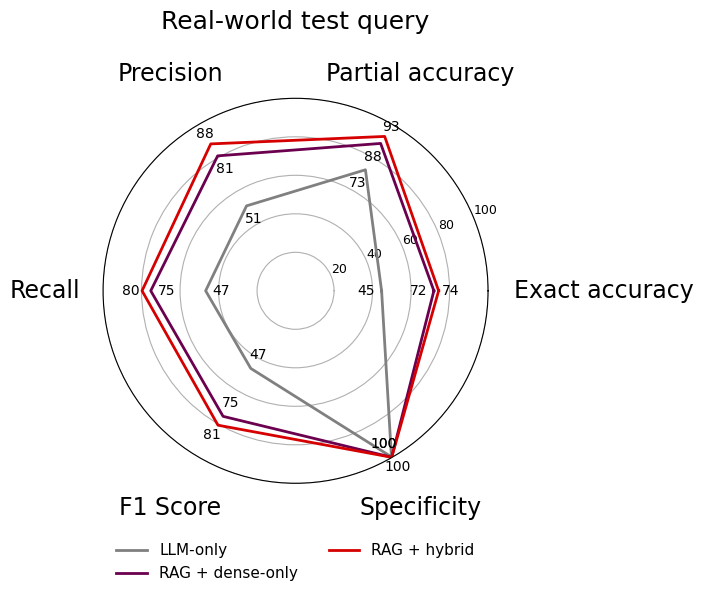

In [70]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'LLM-only': {k: v['5']*100 for k, v in real_test_queries_average['LLM']['default'].items()},
    'RAG + dense-only': {k: v['5']*100 for k, v in real_test_queries_average['RAG']['dense'].items()},
    'RAG + hybrid': {k: v['5']*100 for k, v in real_test_queries_average['RAG']['hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title="Real-world test query",
    colors=['grey',cols[6],cols[0]],
    offsets=[-0.08, -0.08, 0.06],
    # save_path="analysis/figures_rev/Figure4_real_world_test_query_radar_chart.jpeg"
    )

In [71]:
for m in METRICS.keys():
    m_increase = perc_increase(
        old=real_test_queries_average['RAG']['dense'][m]['5'], 
        new=real_test_queries_average['RAG']['hybrid'][m]['5'])
    print(f"{m} increase: {m_increase:.0f}%")

exact increase: 3%
partial increase: 5%
precision increase: 9%
recall increase: 6%
f1 increase: 7%
specificity increase: 0%


In [72]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='hybrid'
model_B='dense'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        evaluator_real_test_queries.evals['RAG'][model_A]['5'][i]['exact_match_acc'],
        evaluator_real_test_queries.evals['RAG'][model_B]['5'][i]['exact_match_acc'],
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
         evaluator_real_test_queries.evals['RAG'][model_A]['5'][i]['partial_match_acc'],
        evaluator_real_test_queries.evals['RAG'][model_B]['5'][i]['partial_match_acc'],
        )
                            )

In [73]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
cohens_g_runs=[]
odds_ratio_runs=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc, exact_effect = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc, partial_effect = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # store per-run effect sizes
    cohens_g_runs.append([exact_effect['cohens_g'], partial_effect['cohens_g']])
    odds_ratio_runs.append([exact_effect['odds_ratio'], partial_effect['odds_ratio']])
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc, pooled_exact_effect = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc, pooled_partial_effect = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)} (Effect size={pooled_exact_effect["cohens_g"]:.3f})')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)} (Effect size={pooled_partial_effect["cohens_g"]:.3f})')

all_mcnemar_results[f'{model_A}_vs_{model_B}']={'exact': pooled_exact_result, 'partial': pooled_partial_result}

hybrid_vs_dense:
Exact: Significance: False; Test Statistic: 2.892857142857143; P-value: 0.08897301170181328 (Effect size=0.357)
Partial: Significance: True; Test Statistic: 1.0; P-value: 7.62939453125e-05 (Effect size=0.895)


In [74]:
all_pvalues=[]
for comparison, output in all_mcnemar_results['hybrid_vs_dense'].items():
    all_pvalues.append(output.pvalue)

_, p_corrected, _, _ = multipletests(all_pvalues, alpha=0.05, method='fdr_bh')
p_corrected

array([0.08897301, 0.00015259])

In [75]:
print(f"Raw: {all_mcnemar_results['hybrid_vs_dense']['exact'].pvalue}, {all_mcnemar_results['hybrid_vs_dense']['partial'].pvalue}")
print(f'Adjusted: {p_corrected[0:2]}')

Raw: 0.08897301170181328, 7.62939453125e-05
Adjusted: [0.08897301 0.00015259]


In [76]:
all_results = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_real_test_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_real_test_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results.append(compare_mode_A_vs_B(dense_partial_failed, hybrid_partial_failed))

arr = np.array(all_results)

summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Dense Success and Hybrid Failed": arr[:,1],
    "Dense Failed and Hybrid Success": arr[:,2],
    "Both Failed": arr[:,3]
})

summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)

                                 mean       std
Both Success                     71.4  0.547723
Dense Success and Hybrid Failed   0.2  0.447214
Dense Failed and Hybrid Success   3.6  0.547723
Both Failed                       5.8  0.447214


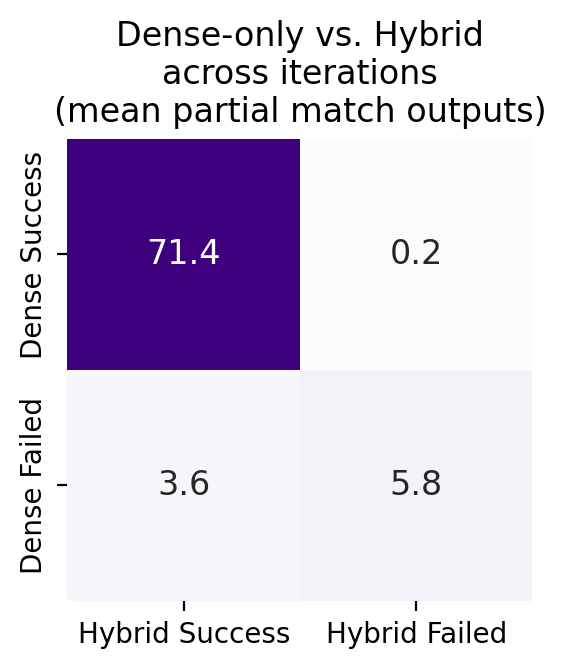

In [77]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

avg_cm = np.array([
    [summary_stats.loc["Both Success","mean"], summary_stats.loc["Dense Success and Hybrid Failed","mean"]],
    [summary_stats.loc["Dense Failed and Hybrid Success","mean"], summary_stats.loc["Both Failed","mean"]]
])
sns.heatmap(avg_cm, annot=True, annot_kws={"fontsize": 12},
            fmt=".1f", cmap="Purples", cbar=False,
            xticklabels=["Hybrid Success", "Hybrid Failed"],
            yticklabels=["Dense Success", "Dense Failed"])
plt.title("Dense-only vs. Hybrid\nacross iterations\n(mean partial match outputs)", fontdict={'fontsize': 12})
save = False
if save == True:
    plt.savefig('analysis/figures_rev/Figure4_real_world_test_partial_match_counts.jpeg', dpi=500, bbox_inches='tight')
plt.show()

In [78]:
all_results_idx = []
for i in range(5): 
    dense_partial_failed = ~np.array(evaluator_real_test_queries.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    hybrid_partial_failed = ~np.array(evaluator_real_test_queries.evals['RAG']['hybrid']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(dense_partial_failed, hybrid_partial_failed))

In [79]:
all_runs=[all_results_idx[i]['both_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

13    5
18    5
42    5
55    5
62    5
59    4
Name: count, dtype: int64

In [80]:
all_runs=[all_results_idx[i]['A_failed_B_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

7     5
11    5
54    5
21    3
Name: count, dtype: int64

In [81]:
all_runs=[all_results_idx[i]['A_success_B_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

59    1
Name: count, dtype: int64

In [82]:
all_runs=[all_results_idx[i]['both_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

0     5
1     5
61    5
60    5
58    5
     ..
28    5
27    5
26    5
25    5
21    2
Name: count, Length: 72, dtype: int64

In [83]:
REAL_QUERY_TEST_REINDEXED=REAL_QUERY_TEST.reset_index()

In [84]:
for i in range(5):
    idx=all_results_idx[i]['both_success']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_TEST_REINDEXED['prompt'][j]}")
        print("============= ground-truth =============")
        print(evaluator_real_test_queries.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= dense =============")
        print(evaluator_real_test_queries.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
        print(evaluator_real_test_queries.llm_output['RAG']['dense']['5'][i][j])
        print("============= hybrid =============")
        print(evaluator_real_test_queries.evals['RAG']['hybrid']['5'][i]['pred_drugs_generic_set_ls'][j])
        print(evaluator_real_test_queries.llm_output['RAG']['hybrid']['5'][i][j])
        break

============= query =============
(0, 0): what drug combination is approved for adults with kras g12c-mutated advanced colorectal cancer who have progressed on chemotherapy?
============= ground-truth =============
{frozenset({'cetuximab', 'adagrasib'})}
============= dense =============
{frozenset({'cetuximab', 'adagrasib'})}
{
    "Status": "success",
    "Treatment 1": {
        "Disease Name": "Colorectal Adenocarcinoma",
        "Disease Phase or Condition": "Locally Advanced or Metastatic",
        "Drug Name": "Cetuximab + Adagrasib",
        "Prior Treatment or Resistance Status": "Progressed on Fluoropyrimidine-, Oxaliplatin-, and Irinotecan-based Chemotherapy",
        "Genomic Features": "KRAS G12C Mutation",
        "FDA-approval status": "Approved under accelerated approval based on objective response rate (ORR) and duration of response (DOR)",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/216340Orig1s000Corrected_lbl.pdf"

#### Compare strategy 4 vs. 5 in real-world queries

##### Real-world validation queries

In [85]:
VAL_MODE_PATHS = {
    "RAG":{
        "dense": VAL_RAG_STRUC_DENSE_FILEPATH
    },
}

evaluator_real_val_stra4_vs_stra5 = Evaluator(
    pipelines=['RAG'],
    strategies=['4','5'],
    metrics=METRICS,
    query=REAL_QUERY_VAL,
    true_dict=REAL_QUERY_TRUE,
    mode_paths=VAL_MODE_PATHS,
    num_iter=NUM_ITER
)

evaluator_real_val_stra4_vs_stra5.run()
evaluator_real_val_stra4_vs_stra5.average()

{'RAG': {'dense': {'exact': {'4': 0.47619047619047616,
    '5': 0.7142857142857143},
   'partial': {'4': 0.6190476190476191, '5': 0.8571428571428571},
   'precision': {'4': 0.9800000000000001, '5': 0.784},
   'recall': {'4': 0.8716666666666667, '5': 0.6716666666666666},
   'f1': {'4': 0.9, '5': 0.7017777777777778},
   'specificity': {'4': 0.9994285714285714, '5': 0.9995428571428573}}}}

In [86]:
all_results_idx = []
for i in range(5):
    stra4_partial_failed = ~np.array(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['partial_match_acc'])
    stra5_partial_failed = ~np.array(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(stra4_partial_failed, stra5_partial_failed)) 
    print(all_results_idx[i])

{'both_success': [3, 4, 5, 6, 9, 14, 15, 16, 17, 18, 20], 'both_failed': [0], 'A_failed_B_success': [1, 2, 8, 10, 11, 12, 13], 'A_success_B_failed': [7, 19]}
{'both_success': [3, 4, 5, 6, 9, 14, 15, 16, 17, 18, 20], 'both_failed': [0], 'A_failed_B_success': [1, 2, 8, 10, 11, 12, 13], 'A_success_B_failed': [7, 19]}
{'both_success': [3, 4, 5, 6, 9, 14, 15, 16, 17, 18, 20], 'both_failed': [0], 'A_failed_B_success': [1, 2, 8, 10, 11, 12, 13], 'A_success_B_failed': [7, 19]}
{'both_success': [3, 4, 5, 6, 9, 14, 15, 16, 17, 18, 20], 'both_failed': [0], 'A_failed_B_success': [1, 2, 8, 10, 11, 12, 13], 'A_success_B_failed': [7, 19]}
{'both_success': [3, 4, 5, 6, 9, 14, 15, 16, 17, 18, 20], 'both_failed': [0], 'A_failed_B_success': [1, 2, 8, 10, 11, 12, 13], 'A_success_B_failed': [7, 19]}


In [87]:
all_results = []
for i in range(5):
    stra4_partial_failed = ~np.array(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['partial_match_acc'])
    stra5_partial_failed = ~np.array(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    all_results.append(compare_mode_A_vs_B(stra4_partial_failed, stra5_partial_failed))
arr = np.array(all_results)
summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Stra4 Success and Stra5 Failed": arr[:,1],
    "Stra4 Failed and Stra5 Success": arr[:,2],
    "Both Failed": arr[:,3]
})
summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)

                                mean  std
Both Success                    11.0  0.0
Stra4 Success and Stra5 Failed   2.0  0.0
Stra4 Failed and Stra5 Success   7.0  0.0
Both Failed                      1.0  0.0


In [159]:
all_results_ls = {'stra4': evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'],
                  'stra5': evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5']}

In [160]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='stra4'
model_B='stra5'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['exact_match_acc'],
        all_results_ls[model_B][i]['exact_match_acc'],
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['partial_match_acc'],
        all_results_ls[model_B][i]['partial_match_acc'],
        )
                            )

In [161]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
cohens_g_runs=[]
odds_ratio_runs=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc, exact_effect = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc, partial_effect = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # store per-run effect sizes
    cohens_g_runs.append([exact_effect['cohens_g'], partial_effect['cohens_g']])
    odds_ratio_runs.append([exact_effect['odds_ratio'], partial_effect['odds_ratio']])
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc, pooled_exact_effect = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc, pooled_partial_effect = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)} (Effect size={pooled_exact_effect["cohens_g"]:.3f})')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)} (Effect size={pooled_partial_effect["cohens_g"]:.3f})')

all_mcnemar_results = {
    f'{model_A}_vs_{model_B}': {'exact': pooled_exact_result, 'partial': pooled_partial_result}
    }

stra4_vs_stra5:
Exact: Significance: True; Test Statistic: 12.8; P-value: 0.000346619351134667 (Effect size=0.556)
Partial: Significance: True; Test Statistic: 12.8; P-value: 0.000346619351134667 (Effect size=0.556)


In [162]:
_, p_corrected, _, _ = multipletests([pooled_exact_result.pvalue, pooled_partial_result.pvalue], alpha=0.05, method='fdr_bh')
p_corrected

array([0.00034662, 0.00034662])

In [163]:
plot_df = pd.concat([
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['exact']).T.mean(axis=1).rename(index='Exact'), 
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['partial']).T.mean(axis=1).rename(index='Partial')], 
                    axis=1)
plot_df

,Exact,Partial
4,0.476190,0.619048
5,0.714286,0.857143


In [164]:
plot_df = pd.concat([
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['exact']).T.mean(axis=1).rename(index='Exact'), 
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['partial']).T.mean(axis=1).rename(index='Partial')], 
                    axis=1)

std_df = pd.concat([
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['exact']).T.std(axis=1).rename(index='Exact'),
    pd.DataFrame(evaluator_real_val_stra4_vs_stra5.results['RAG']['dense']['partial']).T.std(axis=1).rename(index='Partial')], 
                   axis=1)

plot_df = plot_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Accuracy').rename(columns={'index': 'Strategy'})
std_df = std_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Std').rename(columns={'index': 'Strategy'})

plot_df['Accuracy']=plot_df['Accuracy']*100
std_df['Std']=std_df['Std']*100

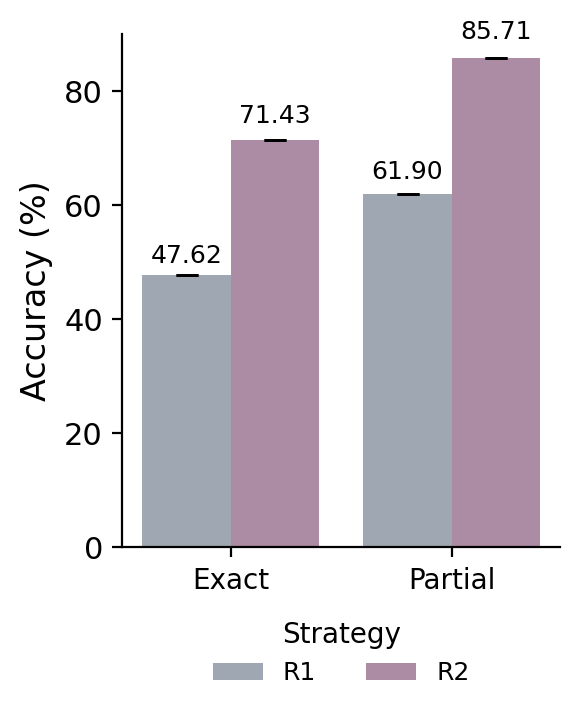

In [165]:
fig, ax = plt.subplots(figsize=(3, 3.7), dpi=200)
order = plot_df['Metric'].unique()
hue_order = plot_df['Strategy'].unique()
cols=sns.color_palette(cc.glasbey)
ax=sns.barplot(
    data=plot_df,
    x='Metric',
    y='Accuracy',
    hue='Strategy',
    palette=[cols[33], cols[66]],
    capsize=0.05,
    errorbar=None,
    alpha=0.7,
    order=order,
    hue_order=hue_order
)

std_df_sorted = std_df.set_index(['Metric', 'Strategy']).loc[
    [(m, h) for h in hue_order for m in order]
].reset_index()

for i, p in enumerate(ax.patches):
    val = p.get_height()
    std = std_df_sorted['Std'].iloc[i]
    ax.errorbar(
        p.get_x() + p.get_width() / 2, val,
        yerr=std,
        fmt='none',
        ecolor='black',
        capsize=4
    )
    ax.annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width()/2., p.get_height()*1.03),
        ha='center', va='bottom', fontsize=9
    )
    
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=10)
sns.despine(top=True, right=True)
plt.legend(title='Strategy', labels=['R1', 'R2'], bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, frameon=False, fontsize=9)
plt.tight_layout()

# save
save = True
if save == True:
    plt.savefig(f'analysis/figures_rev/FigureS3_stra4_vs_stra5_real_world_val_Accuracybar.jpeg', dpi=500, bbox_inches='tight')

plt.show()

In [97]:
#misattributed cases from strategy 4
for i in range(5):
    idx=all_results_idx[i]['A_failed_B_success']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_VAL['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(", ".join([" + ".join([d_ls for d_ls in subset])
               for subset in evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j] 
               ]))
        print("============= stra5 =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 1): are parp inhibitors used for patients with leiomyosarcoma who have mutations in dna damage repair genes?
============= ground-truth =============
set()
============= stra4 =============
olaparib
============= stra5 =============
set()
============= query =============
(0, 2): are alk inhibitors approved for use in tfcp2 fusion positive rhabdomyosarcoma?
============= ground-truth =============
set()
============= stra4 =============
crizotinib
============= stra5 =============
set()
============= query =============
(0, 8): what are available fda-approved targeted therapies in patients with fgfr2 mutated bladder cancer? in which disease setting are they approved (metastatic disease only or peri-operative)?
============= ground-truth =============
set()
============= stra4 =============
infigratinib, pemigatinib, futibatinib
============= stra5 =============
set()
============= query =============
(0, 10): a patient with relapsed high-risk neuro

In [99]:
#failed cases from strategy 5
for i in range(5):
    idx=all_results_idx[i]['A_success_B_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_VAL['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_real_val_stra4_vs_stra5.llm_output['RAG']['dense']['4'][i][j])
        print("============= stra5 =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 7): what fda-approved therapies exist for a stage iv pancreatic ductal adenocarcinoma patient with a ntrk mutation
============= ground-truth =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= stra4 =============
{frozenset({'repotrectinib'}), frozenset({'larotrectinib'}), frozenset({'entrectinib'})}
============= stra5 =============
set()
============= query =============
(0, 19): i have a patient with metastatic hr-negative, her2-low, pd-l1-negative, breast cancer with no germline brca mutation.  for second line, is t-dxd or sacituzumab govitecan preferred?
============= ground-truth =============
{frozenset({'sacituzumab govitecan'}), frozenset({'trastuzumab deruxtecan'})}
============= stra4 =============
{frozenset({'sacituzumab govitecan'}), frozenset({'trastuzumab deruxtecan'})}
============= stra5 =============
set()


In [100]:
#failed cases from both strategies
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_VAL['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j])
        print("============= stra5 =============")
        print(evaluator_real_val_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 0): what is the first-line treatment of metastatic urothelial carcinoma with fgfr3 s249c mutation?
============= ground-truth =============
set()
============= stra4 =============
{frozenset({'erdafitinib'})}
============= stra5 =============
{frozenset({'erdafitinib'})}


##### Real-world test queries

In [166]:
TEST_MODE_PATHS = {
    "RAG":{
        "dense": TEST_RAG_STRUC_DENSE_FILEPATH
    },
}

evaluator_real_test_stra4_vs_stra5 = Evaluator(
    pipelines=['RAG'],
    strategies=['4','5'],
    metrics=METRICS,
    query=REAL_QUERY_TEST,
    true_dict=REAL_QUERY_TRUE,
    mode_paths=TEST_MODE_PATHS,
    num_iter=NUM_ITER
)

evaluator_real_test_stra4_vs_stra5.run()
evaluator_real_test_stra4_vs_stra5.average()

{'RAG': {'dense': {'exact': {'4': 0.5777777777777777, '5': 0.7185185185185186},
   'partial': {'4': 0.7679012345679012, '5': 0.8839506172839506},
   'precision': {'4': 0.8144654088050315, '5': 0.809433962264151},
   'recall': {'4': 0.7673315363881402, '5': 0.7522911051212937},
   'f1': {'4': 0.7619916142557652, '5': 0.7530847559149445},
   'specificity': {'4': 0.9979827750586932, '5': 0.9984489524728053}}}}

In [167]:
all_results = []
for i in range(5): 
    stra4_partial_failed = ~np.array(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['partial_match_acc'])
    stra5_partial_failed = ~np.array(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['partial_match_acc'])
    all_results.append(compare_mode_A_vs_B(stra4_partial_failed, stra5_partial_failed))
arr = np.array(all_results)
summary = pd.DataFrame({
    "Both Success": arr[:,0],
    "Stra4 Success and Stra5 Failed": arr[:,1],
    "Stra4 Failed and Stra5 Success": arr[:,2],
    "Both Failed": arr[:,3]
})
summary_stats = summary.agg(['mean', 'std']).T
print(summary_stats)

                                mean       std
Both Success                    59.2  0.836660
Stra4 Success and Stra5 Failed   3.0  0.000000
Stra4 Failed and Stra5 Success  12.4  0.547723
Both Failed                      6.4  0.547723


In [168]:
all_results_ls = {'stra4': evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['4'],
                  'stra5': evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5']}

In [169]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]
model_A='stra4'
model_B='stra5'

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['exact_match_acc'],
        all_results_ls[model_B][i]['exact_match_acc'],
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_results_ls[model_A][i]['partial_match_acc'],
        all_results_ls[model_B][i]['partial_match_acc'],
        )
                            )

In [170]:
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]
exact_result_bc=[]
partial_result_bc=[]
cohens_g_runs=[]
odds_ratio_runs=[]
pooled_exact = np.array([[0, 0], [0, 0]])
pooled_partial = np.array([[0, 0], [0, 0]])

for i in range(5):
    # run mcnemar's test separately
    exact_result, exact_bc, exact_effect = conduct_mcnemar_test(exact_table_ls[i])
    partial_result, partial_bc, partial_effect = conduct_mcnemar_test(partial_table_ls[i])
    exact_result_ls.append(exact_result)
    partial_result_ls.append(partial_result)
    
    # store per-run effect sizes
    cohens_g_runs.append([exact_effect['cohens_g'], partial_effect['cohens_g']])
    odds_ratio_runs.append([exact_effect['odds_ratio'], partial_effect['odds_ratio']])
    
    # pool matrix
    pooled_exact += np.array(exact_table_ls[i])
    pooled_partial += np.array(partial_table_ls[i])

    # mcnemar's p-values
    exact_result_pval.append(exact_result.pvalue)
    partial_result_pval.append(partial_result.pvalue)
    
    # get discordant (b,c) values (if b > c, model A is better)
    exact_result_bc.append(exact_bc)
    partial_result_bc.append(partial_bc)

# run mcnemar's test on pooled matrix
pooled_exact_result, pooled_exact_bc, pooled_exact_effect = conduct_mcnemar_test(pooled_exact) 
pooled_partial_result, pooled_partial_bc, pooled_partial_effect = conduct_mcnemar_test(pooled_partial)

print(f'{model_A}_vs_{model_B}:')
print(f'Exact: {print_mcnemar_res(pooled_exact_result, alpha=0.05)} (Effect size={pooled_exact_effect["cohens_g"]:.3f})')
print(f'Partial: {print_mcnemar_res(pooled_partial_result, alpha=0.05)} (Effect size={pooled_partial_effect["cohens_g"]:.3f})')

all_mcnemar_results = {
    f'{model_A}_vs_{model_B}': {'exact': pooled_exact_result, 'partial': pooled_partial_result}
    }

stra4_vs_stra5:
Exact: Significance: True; Test Statistic: 40.72727272727273; P-value: 1.7502727179156942e-10 (Effect size=0.740)
Partial: Significance: True; Test Statistic: 27.48051948051948; P-value: 1.5868484191167268e-07 (Effect size=0.610)


In [171]:
_, p_corrected, _, _ = multipletests([pooled_exact_result.pvalue, pooled_partial_result.pvalue], alpha=0.05, method='fdr_bh')
p_corrected

array([3.50054544e-10, 1.58684842e-07])

In [172]:
plot_df = pd.concat([
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['exact']).T.mean(axis=1).rename(index='Exact'), 
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['partial']).T.mean(axis=1).rename(index='Partial')], 
                    axis=1)
plot_df

,Exact,Partial
4,0.577778,0.767901
5,0.718519,0.883951


In [173]:
plot_df = pd.concat([
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['exact']).T.mean(axis=1).rename(index='Exact'), 
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['partial']).T.mean(axis=1).rename(index='Partial')], 
                    axis=1)

std_df = pd.concat([
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['exact']).T.std(axis=1).rename(index='Exact'),
    pd.DataFrame(evaluator_real_test_stra4_vs_stra5.results['RAG']['dense']['partial']).T.std(axis=1).rename(index='Partial')], 
                   axis=1)

plot_df = plot_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Accuracy').rename(columns={'index': 'Strategy'})
std_df = std_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Std').rename(columns={'index': 'Strategy'})

plot_df['Accuracy']=plot_df['Accuracy']*100
std_df['Std']=std_df['Std']*100

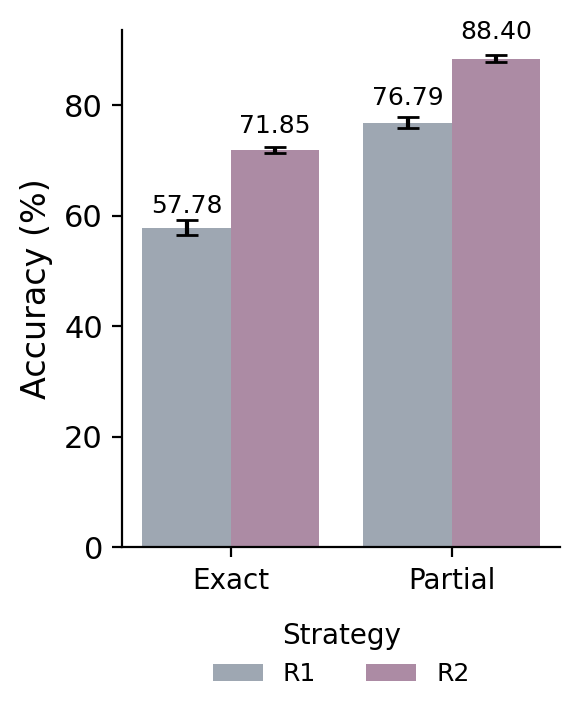

In [174]:
fig, ax = plt.subplots(figsize=(3, 3.7), dpi=200)
order = plot_df['Metric'].unique()
hue_order = plot_df['Strategy'].unique()
cols=sns.color_palette(cc.glasbey)
ax=sns.barplot(
    data=plot_df,
    x='Metric',
    y='Accuracy',
    hue='Strategy',
    palette=[cols[33], cols[66]],
    capsize=0.05,
    errorbar=None,
    alpha=0.7,
    order=order,
    hue_order=hue_order
)

std_df_sorted = std_df.set_index(['Metric', 'Strategy']).loc[
    [(m, h) for h in hue_order for m in order]
].reset_index()

for i, p in enumerate(ax.patches):
    val = p.get_height()
    std = std_df_sorted['Std'].iloc[i]
    ax.errorbar(
        p.get_x() + p.get_width() / 2, val,
        yerr=std,
        fmt='none',
        ecolor='black',
        capsize=4
    )
    ax.annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width()/2., p.get_height()*1.03),
        ha='center', va='bottom', fontsize=9
    )
    
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel(None)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=10)
sns.despine(top=True, right=True)
plt.legend(title='Strategy', labels=['R1', 'R2'], bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, frameon=False, fontsize=9)
plt.tight_layout()

# save
save = True
if save == True:
    plt.savefig(f'analysis/figures_rev/FigureS3_stra4_vs_stra5_real_world_test_Accuracybar.jpeg', dpi=500, bbox_inches='tight')

plt.show()

In [111]:
all_results_idx = []
for i in range(5):
    stra4_partial_failed = ~np.array(all_results_ls['stra4'][i]['partial_match_acc'])
    stra5_partial_failed = ~np.array(all_results_ls['stra5'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(stra4_partial_failed, stra5_partial_failed))
print(all_results_idx[0])

{'both_success': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 14, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 33, 35, 37, 38, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 56, 57, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 'both_failed': [11, 13, 18, 21, 54, 55, 59], 'A_failed_B_success': [15, 20, 28, 31, 32, 34, 36, 39, 40, 41, 58, 60, 65], 'A_success_B_failed': [7, 42, 62]}


In [112]:
all_runs=[all_results_idx[i]['A_failed_B_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

15    5
20    5
28    5
31    5
32    5
39    5
40    5
41    5
58    5
60    5
65    5
34    4
36    1
21    1
59    1
Name: count, dtype: int64

In [113]:
#misattributed cases from strategy 4
for i in range(5):
    idx=all_results_idx[i]['A_failed_B_success']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_TEST['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(", ".join([" + ".join([d_ls for d_ls in subset])
               for subset in evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j] 
               ]))
        print("============= stra5 =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 15): i have a patient with metastatic bladder cancer who has progressed on chemotherapy. genomics testing revealed a focal amplification of the jak2/pd-l1 locus. what are the treatment options?
============= ground-truth =============
set()
============= stra4 =============
pembrolizumab
============= stra5 =============
set()
============= query =============
(0, 20): if a patient with radioactive iodine refractory thyroid cancer progresses on lenvatinib and the tumor has a ras mutation, what do i do?
============= ground-truth =============
set()
============= stra4 =============
pralsetinib, selpercatinib
============= stra5 =============
set()
============= query =============
(0, 28): what targeted treatment option is available for patients with high-risk neuroblastoma and an activating alk mutation?
============= ground-truth =============
set()
============= stra4 =============
crizotinib
============= stra5 =============
set()
=============

In [ ]:
#failed cases from strategy 5
for i in range(5):
    idx=all_results_idx[i]['A_success_B_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_TEST['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j])
        print("============= stra5 =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 7): i have a patient with metastatic hormone receptor-positive, her2-low (ihc 1+) breast cancer who progressed on 1st-line treatment with letrozole and ribociclib. circulating tumor dna analysis reveals a pathogenic deletion in pten. what are approved treatment options in the second-line setting?
============= ground-truth =============
{frozenset({'trastuzumab deruxtecan'}), frozenset({'fulvestrant', 'capivasertib'})}
============= stra4 =============
{frozenset({'fulvestrant', 'ribociclib'})}
============= stra5 =============
set()
============= query =============
(0, 42): i have a patient with newly diagnosed aml that has mutations in tp53 and idh1. are there any therapies that i should be thinking about in this setting?
============= ground-truth =============
{frozenset({'ivosidenib'})}
============= stra4 =============
{frozenset({'azacitidine', 'ivosidenib'}), frozenset({'ivosidenib'})}
============= stra5 =============
set()
============= 

In [116]:
#failed cases from both strategies
for i in range(5):
    idx=all_results_idx[i]['both_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {REAL_QUERY_TEST['prompt'].iloc[j]}")
        print("============= ground-truth =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['true_drugs_generic_set_ls'][j])
        print("============= stra4 =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['4'][i]['pred_drugs_generic_set_ls'][j])
        print("============= stra5 =============")
        print(evaluator_real_test_stra4_vs_stra5.evals['RAG']['dense']['5'][i]['pred_drugs_generic_set_ls'][j])
    break

============= query =============
(0, 11): 66 yo patient with previously resected clear-cell renal cell carcinoma, presents now with local unresectable recurrence. genetic testing is notable for vhl and pbrm1 mutations, as well as msi-h. what oprions are recommended for systemic treatment?
============= ground-truth =============
set()
============= stra4 =============
{frozenset({'pembrolizumab'})}
============= stra5 =============
{frozenset({'pembrolizumab'})}
============= query =============
(0, 13): 73 yo patient with a new diagnosis of metastatic urothelial carcinoma. molecular testing reveals fgfr3 g370c mutations and her2 ihc 3+ status. what options would you recommend for systemic treatment?
============= ground-truth =============
set()
============= stra4 =============
{frozenset({'trastuzumab deruxtecan'}), frozenset({'erdafitinib'})}
============= stra5 =============
{frozenset({'erdafitinib'})}
============= query =============
(0, 18): i have a patient with radioactive 

### Compare with CIVIC context augmentation

In [123]:
civic_db_raw = pd.read_csv("external-validation/non-moa-database/civic/civic-db/01-Oct-2025-ClinicalEvidenceSummaries.tsv", sep="\t")
civic_db_raw

,molecular_profile,molecular_profile_id,disease,doid,phenotypes,therapies,therapy_interaction_type,evidence_type,evidence_direction,evidence_level,...,citation,nct_ids,rating,evidence_status,evidence_id,variant_origin,last_review_date,evidence_civic_url,molecular_profile_civic_url,is_flagged
0,JAK2 V617F,64,Lymphoid Leukemia,1037.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Levine et al., 2005",NaN,4.0,accepted,1,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/1,https://civicdb.org/links/molecular_profiles/64,False
1,PDGFRA D842V,99,Gastrointestinal Stromal Tumor,9253.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Lasota et al., 2004",NaN,3.0,accepted,2,Somatic,2023-01-09 21:46:27 UTC,https://civicdb.org/links/evidence_items/2,https://civicdb.org/links/molecular_profiles/99,False
2,DNMT3A R882,32,Acute Myeloid Leukemia,9119.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Ribeiro et al., 2012",NaN,3.0,accepted,4,Somatic,2023-01-09 21:46:25 UTC,https://civicdb.org/links/evidence_items/4,https://civicdb.org/links/molecular_profiles/32,False
3,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Levine et al., 2005",NaN,4.0,accepted,5,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/5,https://civicdb.org/links/molecular_profiles/64,False
4,JAK2 V617F,64,Chronic Myeloid Leukemia,8552.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Levine et al., 2005",NaN,4.0,accepted,6,Somatic,2023-01-09 21:46:26 UTC,https://civicdb.org/links/evidence_items/6,https://civicdb.org/links/molecular_profiles/64,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,FGFR1 Amplification,263,Breast Cancer,1612.0,NaN,NaN,NaN,Prognostic,Supports,B,...,"O'Leary et al., 2021",NaN,5.0,accepted,12486,Somatic,2025-08-13 19:17:43 UTC,https://civicdb.org/links/evidence_items/12486,https://civicdb.org/links/molecular_profiles/263,False
4594,NPM1 MUTATION,3007,Acute Myeloid Leukemia With Mutated NPM1,81089.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Falini et al., 2005",NaN,4.0,accepted,12494,Somatic,2025-09-02 02:14:13 UTC,https://civicdb.org/links/evidence_items/12494,https://civicdb.org/links/molecular_profiles/3007,False
4595,NPM1 MUTATION,3007,Acute Myeloid Leukemia With Mutated NPM1,81089.0,NaN,NaN,NaN,Diagnostic,Supports,B,...,"Döhner et al., 2005",NaN,3.0,accepted,12495,Somatic,2025-08-29 23:21:48 UTC,https://civicdb.org/links/evidence_items/12495,https://civicdb.org/links/molecular_profiles/3007,False
4596,FGFR1 Amplification,263,Breast Cancer,1612.0,NaN,NaN,NaN,Prognostic,Supports,B,...,"Mouron et al., 2021",NaN,5.0,accepted,12497,Somatic,2025-09-10 19:28:07 UTC,https://civicdb.org/links/evidence_items/12497,https://civicdb.org/links/molecular_profiles/263,False


#### Compare under strategy 7 (flexible, scope-expanded) - all test queries

In [ ]:
QUERY_TEST=pd.read_csv(f"data/real_world_db/real_world_test__v2.csv", index_col=0)
QUERY_RAW=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers.csv")
QUERY_RAW=QUERY_RAW.dropna(subset='Questions').reset_index(drop=True)

query_in_scope=QUERY_RAW[
    (QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (QUERY_RAW['Asking_therapy']==True)
    ].index.tolist()

query_multiple_biomarkers=QUERY_RAW[
    (QUERY_RAW['Asking_genomic_biomarker_linked_therapy']==True) &
    (QUERY_RAW['Asking_therapy']==True) &
    (QUERY_RAW['Multiple_biomarkers']==True)
    ].index.tolist()
# add boolean columns to group queries
QUERY_TEST.loc[QUERY_TEST.index.isin(query_in_scope), 'within_scope']=True
QUERY_TEST.loc[QUERY_TEST.index.isin(query_multiple_biomarkers), 'multiple_biomarkers']=True

In [136]:
num_iter = 5
strategies = ["5","7"]
LLM_FILEPATH='output/LLM_res_gpt4o_default/realworld_test_v2'
MOA_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_db_v202510_hybrid'
CIVIC_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/civic_structured_realworld_test_v2_hybrid'
QUERY_TRUE_OUT = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "LLM":{
        "llm": LLM_FILEPATH
    },
    "RAG":{
        "moa_hybrid": MOA_HYBRID_FILEPATH,
        "civic_hybrid": CIVIC_HYBRID_FILEPATH
    }
}

evaluator_civic_stra7_all_queries = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=QUERY_TEST,
    true_dict=QUERY_TRUE_OUT,
    mode_paths=mode_paths,
    num_iter=num_iter,
)

evaluator_civic_stra7_all_queries.run()
average = evaluator_civic_stra7_all_queries.average()
average

{'LLM': {'llm': {'exact': {'5': 0.37777777777777777, '7': 0.3234567901234568},
   'partial': {'5': 0.7333333333333334, '7': 0.6864197530864197},
   'precision': {'5': 0.41884057971014493, '7': 0.4705314009661836},
   'recall': {'5': 0.3756383712905452, '7': 0.4192132505175984},
   'f1': {'5': 0.38013154317502146, '7': 0.4253692201518288},
   'specificity': {'5': 0.9957702860266533, '7': 0.9948411977007972}}},
 'RAG': {'moa_hybrid': {'exact': {'5': 0.5308641975308642,
    '7': 0.5259259259259259},
   'partial': {'5': 0.7654320987654321, '7': 0.7629629629629628},
   'precision': {'5': 0.6768115942028985, '7': 0.6737060041407867},
   'recall': {'5': 0.5798585231193927, '7': 0.5843029675638372},
   'f1': {'5': 0.5964553803684238, '7': 0.6001603227690183},
   'specificity': {'5': 0.9987291867979448, '7': 0.9983403539525482}},
  'civic_hybrid': {'exact': {'5': 0.30864197530864196,
    '7': 0.3679012345679012},
   'partial': {'5': 0.5111111111111112, '7': 0.617283950617284},
   'precision': {

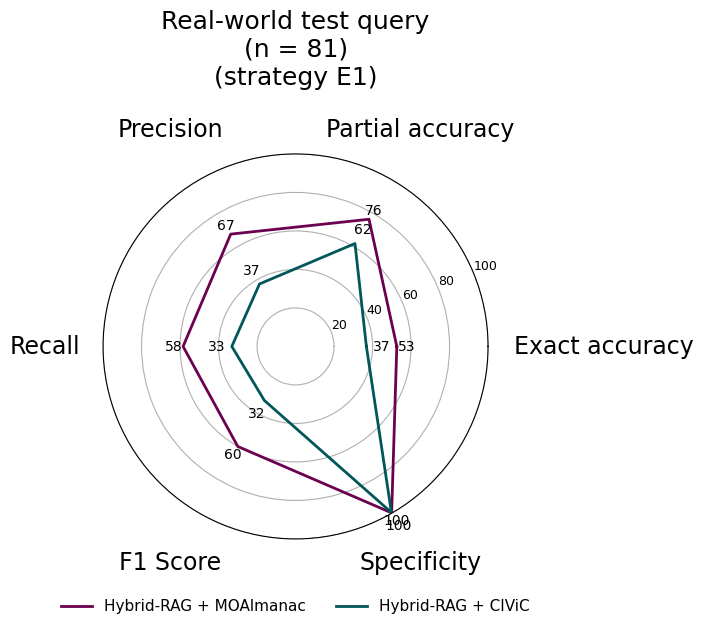

In [ ]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    # 'LLM-only': {k: v['7']*100 for k, v in average['LLM']['llm'].items()},
    'Hybrid-RAG + MOAlmanac': {k: v['7']*100 for k, v in average['RAG']['moa_hybrid'].items()},
    'Hybrid-RAG + CIViC': {k: v['7']*100 for k, v in average['RAG']['civic_hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title="Real-world test query\n(n = 81)\n(strategy E1)",
    colors=[cols[6],cols[9]],
    offsets=[0.05, 0.08],
    save_path="analysis/figures_rev/FigureS4_real_world_test_query_moa_vs_civic_radar_chart.jpeg"
    )

In [138]:
all_results_idx = []
for i in range(5):
    moa_partial_failed = ~np.array(evaluator_civic_stra7_all_queries.evals['RAG']['moa_hybrid']['7'][i]['partial_match_acc'])
    civic_partial_failed = ~np.array(evaluator_civic_stra7_all_queries.evals['RAG']['civic_hybrid']['7'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(moa_partial_failed, civic_partial_failed))
print(all_results_idx[0])

{'both_success': [0, 2, 3, 7, 8, 9, 12, 16, 17, 19, 22, 23, 27, 29, 31, 32, 33, 34, 35, 38, 43, 45, 48, 49, 50, 51, 52, 53, 54, 57, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78], 'both_failed': [13, 18, 24, 36, 37, 41, 55, 58, 59, 60, 62, 79, 80], 'A_failed_B_success': [15, 20, 28, 39, 42, 47], 'A_success_B_failed': [1, 4, 5, 6, 10, 11, 14, 21, 25, 26, 30, 40, 44, 46, 56, 61, 67]}


In [ ]:
all_runs=[all_results_idx[i]['A_success_B_failed'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

1     5
4     5
67    5
61    5
56    5
46    5
44    5
40    5
30    5
26    5
25    5
21    5
14    5
10    5
6     5
5     5
11    4
38    1
Name: count, dtype: int64

In [142]:
QUERY_TEST_REINDEXED=QUERY_TEST.reset_index()

In [143]:
#A success B failed 
for i in range(5):
    idx=all_results_idx[i]['A_success_B_failed']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {QUERY_TEST_REINDEXED['prompt'][j]}")
        print("============= ground-truth =============")
        gd = evaluator_civic_stra7_all_queries.evals['RAG']['moa_hybrid']['7'][i]['true_drugs_generic_set_ls'][j]
        print(gd)
        print("============= moa_hybrid =============")
        print(evaluator_civic_stra7_all_queries.evals['RAG']['moa_hybrid']['7'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_civic_stra7_all_queries.llm_input['RAG']['dense']['4'][i][j])
        print("============= civic_hybrid =============")
        print(evaluator_civic_stra7_all_queries.evals['RAG']['civic_hybrid']['7'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_civic_stra7_all_queries.llm_input['RAG']['civic_hybrid']['7'][i][j])
    break

============= query =============
(0, 1): what therapy is recommended for patients with recurrent or advanced intrahepatic cholangiocarcinoma and fgfr2 fusion?
============= ground-truth =============
{frozenset({'futibatinib'})}
============= moa_hybrid =============
{frozenset({'infigratinib'}), frozenset({'pemigatinib'}), frozenset({'futibatinib'})}
============= civic_hybrid =============
{frozenset({'derazantinib'})}
============= query =============
(0, 4): i have a patient with cdk12 mutated metastatic castrate-resistant prostate cancer which has progressed on adt, abiraterone, and radium. are there any biomarker-directed therapies that he would be eligible for?
============= ground-truth =============
{frozenset({'talazoparib', 'enzalutamide'}), frozenset({'olaparib'})}
============= moa_hybrid =============
{frozenset({'talazoparib', 'enzalutamide'}), frozenset({'olaparib'})}
============= civic_hybrid =============
set()
============= query =============
(0, 5): i have a pati

In [144]:
for i in range(5):
    idx=all_results_idx[i]['A_failed_B_success']
    for j in idx:
        print("============= query =============")
        print(f"{i,  j}: {QUERY_TEST_REINDEXED['prompt'][j]}")
        print("============= ground-truth =============")
        gd = evaluator_civic_stra7_all_queries.evals['RAG']['moa_hybrid']['7'][i]['true_drugs_generic_set_ls'][j]
        print(gd)
        print("============= moa_hybrid =============")
        print(evaluator_civic_stra7_all_queries.evals['RAG']['moa_hybrid']['7'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_civic_stra7_all_queries.llm_input['RAG']['dense']['4'][i][j])
        print("============= civic_hybrid =============")
        print(evaluator_civic_stra7_all_queries.evals['RAG']['civic_hybrid']['7'][i]['pred_drugs_generic_set_ls'][j])
        # print(evaluator_civic_stra7_all_queries.llm_input['RAG']['civic_hybrid']['7'][i][j])
    break

============= query =============
(0, 15): i have a patient with metastatic bladder cancer who has progressed on chemotherapy. genomics testing revealed a focal amplification of the jak2/pd-l1 locus. what are the treatment options?
============= ground-truth =============
{frozenset({'pembrolizumab', 'enfortumab vedotin'})}
============= moa_hybrid =============
set()
============= civic_hybrid =============
{frozenset({'nivolumab'}), frozenset({'pembrolizumab'})}
============= query =============
(0, 20): if a patient with radioactive iodine refractory thyroid cancer progresses on lenvatinib and the tumor has a ras mutation, what do i do?
============= ground-truth =============
{frozenset({'cabozantinib'}), frozenset({'sorafenib'})}
============= moa_hybrid =============
set()
============= civic_hybrid =============
{frozenset({'refametinib', 'sorafenib'})}
============= query =============
(0, 28): what targeted treatment option is available for patients with high-risk neuroblastom

#### Compare under strategy 7 (flexible, scope-expanded) - offlabel queries only

In [145]:
# get appropriate indices
QUERY_TEST_REINDEXED=QUERY_TEST.reset_index()
within_scope_ind=QUERY_TEST_REINDEXED[
    QUERY_TEST_REINDEXED['index']
    .isin(QUERY_TEST[QUERY_TEST['within_scope']==True].index)
    ].index.tolist()

In [146]:
QUERY_RAW=pd.read_csv("data/real_world_db/updated_real_world_queries_answers__v2.csv", index_col=0)
with_offlabel_idx=QUERY_RAW[~QUERY_RAW['Offlabel_groundtruth_therapies__v1'].isna()].index

QUERY_TEST_REINDEXED=QUERY_TEST.reset_index()
with_offlabel_local_idx=QUERY_TEST_REINDEXED[QUERY_TEST_REINDEXED['index'].isin(with_offlabel_idx)].index.tolist()
print(with_offlabel_local_idx)
print(len(with_offlabel_local_idx))

[7, 9, 15, 20, 24, 28, 37, 47, 48, 51]
10


In [147]:
num_iter = 5
strategies = ["5","7"]
LLM_FILEPATH='output/LLM_res_gpt4o_default/realworld_test_v2'
MOA_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/structured_realworld_test_v2_db_v202510_hybrid'
CIVIC_HYBRID_FILEPATH='output/RAG_res_gpt4o_default/civic_structured_realworld_test_v2_hybrid'
QUERY_TEST = pd.read_csv(f"data/real_world_db/real_world_test__v2.csv", index_col=0)
QUERY_TRUE_OUT = load_object("data/real_world_db/real_world_query_therapy_pair_dict.pkl")

mode_paths = {
    "LLM":{
        "llm": LLM_FILEPATH
    },
    "RAG":{
        "moa_hybrid": MOA_HYBRID_FILEPATH,
        "civic_hybrid": CIVIC_HYBRID_FILEPATH
    }
}

evaluator_civic_stra7_queries = Evaluator(
    pipelines=['LLM','RAG'],
    strategies=strategies,
    metrics=METRICS,
    query=QUERY_TEST,
    true_dict=QUERY_TRUE_OUT,
    mode_paths=mode_paths,
    num_iter=num_iter,
    subset_idx=with_offlabel_local_idx
)

evaluator_civic_stra7_queries.run()
average = evaluator_civic_stra7_queries.average()
average

{'LLM': {'llm': {'exact': {'5': 0.12, '7': 0.1},
   'partial': {'5': 0.52, '7': 0.44000000000000006},
   'precision': {'5': 0.07777777777777779, '7': 0.07407407407407407},
   'recall': {'5': 0.040740740740740744, '7': 0.04444444444444444},
   'f1': {'5': 0.05000000000000001, '7': 0.04987654320987654},
   'specificity': {'5': 0.9928862969884144, '7': 0.9886019505858334}}},
 'RAG': {'moa_hybrid': {'exact': {'5': 0.1, '7': 0.1},
   'partial': {'5': 0.4, '7': 0.4},
   'precision': {'5': 0.2777777777777778, '7': 0.2761904761904762},
   'recall': {'5': 0.09629629629629628, '7': 0.10518518518518519},
   'f1': {'5': 0.12433862433862435, '7': 0.1340659340659341},
   'specificity': {'5': 0.9980952380952381, '7': 0.997347521503946}},
  'civic_hybrid': {'exact': {'5': 0.1, '7': 0.3},
   'partial': {'5': 0.4, '7': 0.7200000000000001},
   'precision': {'5': 0.2962962962962963, '7': 0.39814814814814814},
   'recall': {'5': 0.07777777777777778, '7': 0.3},
   'f1': {'5': 0.1181657848324515, '7': 0.2514

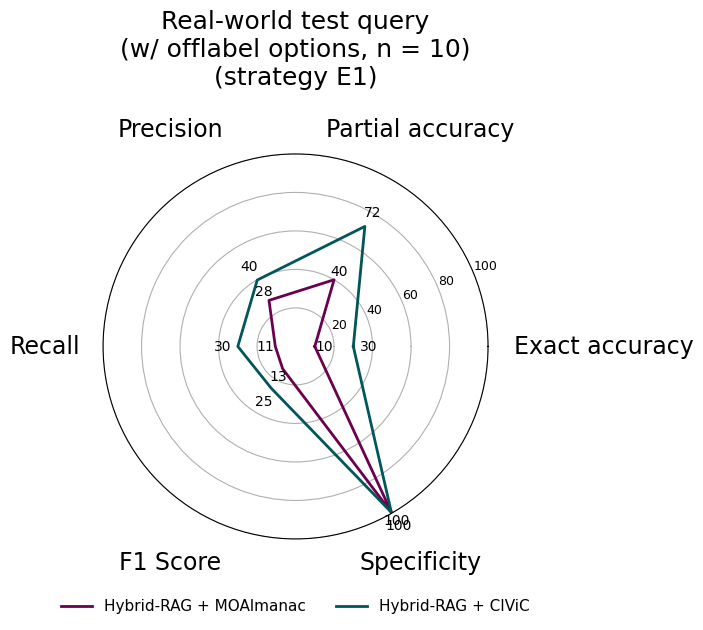

In [ ]:
cols = sns.color_palette(cc.glasbey)

eval_metrics_text = dict(zip(METRICS.keys(),
                             ['Exact accuracy','Partial accuracy','Precision','Recall','F1 Score','Specificity']))

plot_results = {
    'Hybrid-RAG + MOAlmanac': {k: v['7']*100 for k, v in average['RAG']['moa_hybrid'].items()},
    'Hybrid-RAG + CIViC': {k: v['7']*100 for k, v in average['RAG']['civic_hybrid'].items()},
}

plot_radar_chart(
    eval_results=plot_results, 
    metrics=eval_metrics_text.keys(), 
    metric_labels=eval_metrics_text,
    title="Real-world test query\n(w/ offlabel options, n = 10)\n(strategy E1)",
    colors=[cols[6],cols[9]],
    offsets=[0.05, 0.08],
    save_path="analysis/figures_rev/FigureS4_real_world_test_offlabel_query_moa_vs_civic_radar_chart.jpeg"
    )

In [ ]:
all_results_idx = []
for i in range(5): 
    moa_hybrid_partial_failed = ~np.array(evaluator_civic_stra7_queries.evals['RAG']['moa_hybrid']['7'][i]['partial_match_acc'])
    civic_hybrid_partial_failed = ~np.array(evaluator_civic_stra7_queries.evals['RAG']['civic_hybrid']['7'][i]['partial_match_acc'])
    all_results_idx.append(compare_mode_A_vs_B_idx(moa_hybrid_partial_failed, civic_hybrid_partial_failed))

In [ ]:
all_runs=[all_results_idx[i]['A_failed_B_success'] for i in range(5)]
pd.Series([x for run in all_runs for x in run]).value_counts()

2    5
5    5
7    5
3    1
Name: count, dtype: int64

### Supplementary Materials

#### Figure S1. Distribution of structured/unstructured context length

In [152]:
# function to calculate IQR (interquartile range)
def calc_iqr(chunk_size_list):
    q1 = np.percentile(chunk_size_list, 25)
    q3 = np.percentile(chunk_size_list, 75)
    iqr = f'{q1}-{q3}'
    return(iqr)

# import tiktoken
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")  # or "gpt-4", "gpt-3.5-turbo", etc.

Unstructured dataset (v2024)

In [153]:
# load unstructured context derived from FDA drug label indication and usage sections (deduplicated, full)
with open(os.path.join(root_dir,"data/unstructured_context_chunks.json"), "r") as f:
    unstructured_dataset = json.load(f)
len(unstructured_dataset)

56

# chunks: 56
Min: 47
Max: 2476
Mean: 238.16071428571428
Median: 162.0
IQR: 126.75-239.5


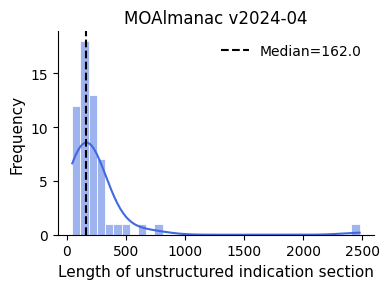

In [27]:
# get chunk size in tokens
unstruc_chunk_size=[len(encoding.encode(chunk)) for chunk in unstructured_dataset]
print(f"# chunks: {len(unstruc_chunk_size)}")
print(f"Min: {np.min(unstruc_chunk_size)}")
print(f"Max: {np.max(unstruc_chunk_size)}")
print(f"Mean: {np.mean(unstruc_chunk_size)}")
print(f"Median: {np.median(unstruc_chunk_size)}")
print(f"IQR: {calc_iqr(unstruc_chunk_size)}")

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(unstruc_chunk_size, 
             bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax
             )

# median line
plt.axvline(np.median(unstruc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label=f'Median={np.median(unstruc_chunk_size)}', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of unstructured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add the legend
ax.legend(ncol=1, frameon=False)
ax.set_title('MOAlmanac v2024-04')

# save plot
save = True
if save == True:
    plt.savefig('analysis/figures_rev/FigureS1_unstructuredlength_dist_v2024.jpeg', dpi=500, bbox_inches='tight')

plt.show()

Unstructured dataset (v2025)

In [28]:
# load unstructured context derived from FDA drug label indication and usage sections (deduplicated, full)
with open(f"data/latest_db/indexes/text-embedding-3-small_fda_unstructured_context__{_VERSION}.json", "r") as f:
    unstructured_dataset = json.load(f)
len(unstructured_dataset)

106

# chunks: 106
Min: 35
Max: 2357
Mean: 204.0188679245283
Median: 131.5
IQR: 94.5-230.75


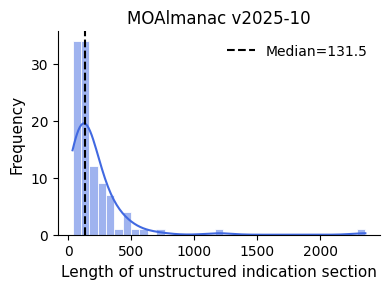

In [29]:
# get chunk size in tokens
unstruc_chunk_size=[len(encoding.encode(chunk)) for chunk in unstructured_dataset]
print(f"# chunks: {len(unstruc_chunk_size)}")
print(f"Min: {np.min(unstruc_chunk_size)}")
print(f"Max: {np.max(unstruc_chunk_size)}")
print(f"Mean: {np.mean(unstruc_chunk_size)}")
print(f"Median: {np.median(unstruc_chunk_size)}")
print(f"IQR: {calc_iqr(unstruc_chunk_size)}")

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(unstruc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(unstruc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label=f'Median={np.median(unstruc_chunk_size)}', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of unstructured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add the legend
ax.set_title('MOAlmanac v2025-10')
ax.legend(ncol=1, frameon=False)

# save plot
save = True
if save == True:
    plt.savefig('analysis/figures_rev/FigureS1_unstructuredlength_dist_v2025.jpeg', dpi=500, bbox_inches='tight')

plt.show()

Structured dataset (v2024)

In [30]:
# load structured context derived from moalmanac data fields
with open(os.path.join(root_dir,"data/structured_context_chunks.json"), "r") as f:
    structured_dataset = json.load(f)

len(structured_dataset)

234

# chunks: 234
Min: 130
Max: 284
Mean: 187.10683760683762
Median: 181.0
IQR: 165.0-203.5


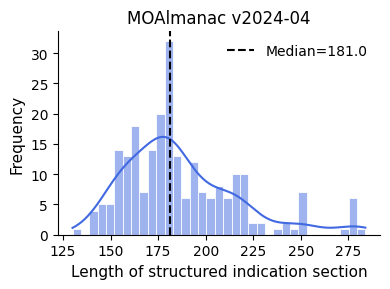

In [32]:
# get chunk size
struc_chunk_size=[len(encoding.encode(chunk)) for chunk in structured_dataset]
print(f"# chunks: {len(struc_chunk_size)}")
print(f"Min: {np.min(struc_chunk_size)}")
print(f"Max: {np.max(struc_chunk_size)}")
print(f"Mean: {np.mean(struc_chunk_size)}")
print(f"Median: {np.median(struc_chunk_size)}")
print(f"IQR: {calc_iqr(struc_chunk_size)}")

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(struc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(struc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label=f'Median={np.median(struc_chunk_size)}', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of structured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add legend
ax.set_title('MOAlmanac v2024-04')
ax.legend(ncol=1, frameon=False)

# save plot
save = True
if save == True:
    plt.savefig('analysis/figures_rev/FigureS1_structuredlength_dist_v2024.jpeg', dpi=500, bbox_inches='tight')

plt.show()


Structured dataset (v2025)

In [33]:
# load structured context derived from moalmanac data fields
with open(f"data/latest_db/indexes/text-embedding-3-small_fda_structured_context__{_VERSION}.json", "r") as f:
    structured_dataset = json.load(f)
len(structured_dataset)

651

# chunks: 651
Min: 95
Max: 232
Mean: 156.4331797235023
Median: 156.0
IQR: 136.0-174.0


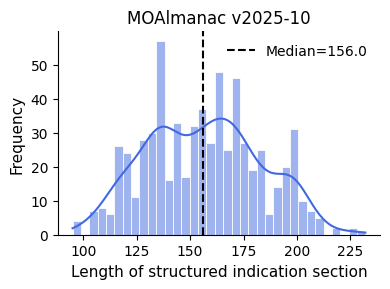

In [34]:
# get chunk size
struc_chunk_size=[len(encoding.encode(chunk)) for chunk in structured_dataset]
print(f"# chunks: {len(struc_chunk_size)}")
print(f"Min: {np.min(struc_chunk_size)}")
print(f"Max: {np.max(struc_chunk_size)}")
print(f"Mean: {np.mean(struc_chunk_size)}")
print(f"Median: {np.median(struc_chunk_size)}")
print(f"IQR: {calc_iqr(struc_chunk_size)}")

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(struc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(struc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label=f'Median={np.median(struc_chunk_size)}', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of structured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add legend
ax.set_title('MOAlmanac v2025-10')
ax.legend(ncol=1, frameon=False)

# save plot
save = True
if save == True:
    plt.savefig('analysis/figures_rev/FigureS1_structuredlength_dist_v2025.jpeg', dpi=500, bbox_inches='tight')

plt.show()


#### Figure S2. Distribution of real-world query cancer type

In [154]:
real_world_query=pd.read_csv("data/real_world_db/real_world_db_split__v2.csv", index_col=0)
real_world_query['cancer_type']=real_world_query['cancer_type'].apply(ast.literal_eval)
real_world_query.head()

,prompt,cancer_category,cancer_type,biomarker,dataset
0,what is the first-line treatment of metastatic...,GU,"[urothelial carcinoma, metastatic]",['fgfr3'],validation
1,are parp inhibitors used for patients with lei...,Sarcoma,[leiomyosarcoma],"['dna', 'parp']",validation
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,[rhabdomyosarcoma],"['alk', 'tfcp2']",validation
3,for a patient with cancer metastatic prostate ...,GU,"[prostate cancer, cancer]",['brca2'],validation
4,for a patient with her2+ breast cancer after n...,Breast,"[breast cancer, disease]",['her2'],validation


In [155]:
cancer_mapping={
    'breast cancer':['breast cancer','lobular breast cancer','breast carcinoma'],
    'bladder cancer':['bladder cancer','urothelial carcinoma','muscle-invasive bladder cancer'],
    'neuroblastoma':['neuroblastoma','high-risk neuroblastoma'],
    'prostate cancer':['prostate cancer'],
    'colorectal cancer':['colorectal cancer','colo-rectal carcinoma','ascending colon adenocarcinoma','colon adenocarcinoma'],
    'cholangiocarcinoma':['cholangiocarcinoma','intrahepatic cholangiocarcinoma'],
    'lung cancer':['lung cancer','lung adenocarcinoma','non-small cell lung adenocarcinoma','non-small cell lung cancer','non small cell lung cancer'],
    'osteosarcoma':['osteosarcoma'],
    'thyroid cancer':['thyroid cancer','anaplastic thyroid cancer','medullary thyroid cancer'],
    'follicular lymphoma':['follicular lymphoma'],
    'hepatoblastoma':['hepatoblastoma'],
    'rhabdomyosarcoma':['rhabdomyosarcoma'],
    'nut midline carcinoma':['nut midline carcinoma'],
    'stomach cancer':['gastric adenocarcinoma','gastroesophageal junction adenocarcinoma'],
    'ovarian cancer':['high grade serious ovarian carcinoma'],
    'kidney cancer':['kidney cancer','clear-cell renal cell carcinoma tumor','clear-cell renal cell carcinoma','clear-cell kidney cancer'],
    'testicular cancer':['testicular cancer'],
    'biliary tract cancer':['biliary tract cancer'],
    'pancreatic cancer':['pancreatic cancer','pancreatic adenocarcinoma','pancreatic ductal adenocarcinoma'],
    'lymphoid neoplasms':['lymphoid neoplasms'],
    'desmoid tumors':['desmoid tumors'],
    'wilms tumor':['wilms tumor','high grade wilms tumor'],
    'peripheral nerve sheath tumor':['peripheral nerve sheath tumor'],
    'oligodendroglioma':['oligodendroglioma'],
    'melanoma':['melanoma'],
    'ewing sarcoma':['ewing sarcoma'],
    'acute myeloid leukemia':['acute myeloid leukemia'],
    'medulloblastoma':['medulloblastoma'],
    'leiomyosarcoma':['leiomyosarcoma'],
    'endometrial cancer':['endometrial carcinoma'],
    'b-cell acute lymphoblastic leukemia':['b-cell acute lymphoblastic leukemia','b-all'],
    'midline glioma':['midline glioma'],
    'anaplastic large cell lymphoma':['anaplastic large cell lymphoma']
}

In [156]:
real_world_query['standardized_cancer_type']=None
for k, v in cancer_mapping.items():
    for idx, c in enumerate(real_world_query['cancer_type']):
        if set(c).intersection(set(v)):
            real_world_query.at[idx, 'standardized_cancer_type']=k

In [157]:
ner_missed_cancer=['unspecified',
 'unspecified',
 'acute myeloid leukemia',
 'lung cancer',
 'melanoma',
 'thyroid cancer',
 'b-cell acute lymphoblastic leukemia',
 'b-cell acute lymphoblastic leukemia',
 'acute myeloid leukemia',
 'midline glioma',
 'acute myeloid leukemia',
 'acute myeloid leukemia',
 'chronic lymphocytic leukemia',
 'unspecified',
 'colorectal cancer',
 'colorectal cancer',
 'cholangiocarcinoma',
 'anaplastic large cell lymphoma'
 ]
ner_missed_idx=real_world_query[real_world_query['standardized_cancer_type'].isna()].index
real_world_query.loc[ner_missed_idx, "standardized_cancer_type"]=ner_missed_cancer

In [158]:
real_world_query

,prompt,cancer_category,cancer_type,biomarker,dataset,standardized_cancer_type
0,what is the first-line treatment of metastatic...,GU,"[urothelial carcinoma, metastatic]",['fgfr3'],validation,bladder cancer
1,are parp inhibitors used for patients with lei...,Sarcoma,[leiomyosarcoma],"['dna', 'parp']",validation,leiomyosarcoma
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,[rhabdomyosarcoma],"['alk', 'tfcp2']",validation,rhabdomyosarcoma
3,for a patient with cancer metastatic prostate ...,GU,"[prostate cancer, cancer]",['brca2'],validation,prostate cancer
4,for a patient with her2+ breast cancer after n...,Breast,"[breast cancer, disease]",['her2'],validation,breast cancer
...,...,...,...,...,...,...
97,what is an acceptable treatment in patients wi...,Breast,[breast cancer],"['her2', 'estrogen receptor', 'esr1']",test,breast cancer
98,what is an acceptable regimen in patients with...,GI,[gastroesophageal junction adenocarcinoma],['her2'],test,stomach cancer
99,are there any genomically guided therapies tha...,GU,[prostate cancer],['fda'],test,prostate cancer
100,which drugs are currently approved for the tre...,Other,[desmoid tumors],[],test,desmoid tumors


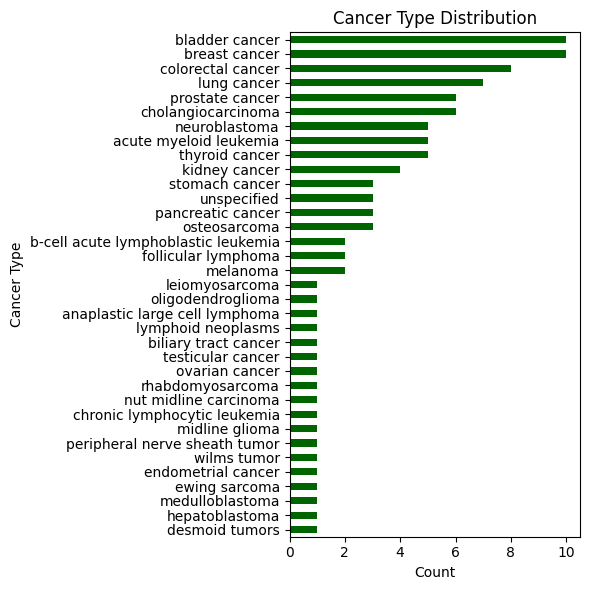

In [ ]:
counts=real_world_query['standardized_cancer_type'].value_counts()
counts[::-1].plot(
    kind="barh", 
    color="darkgreen",
    figsize=(6, 6)
    )
plt.xlabel("Count")
plt.ylabel("Cancer Type")
plt.title("Cancer Type Distribution")
plt.tight_layout()

save = True
if save == True:
    plt.savefig(f'analysis/figures_rev/FigureS2_realworld_cancerSpecific_bar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

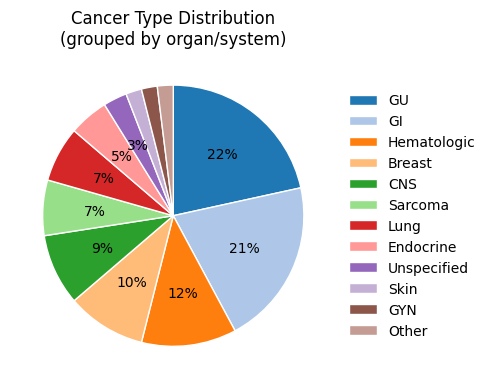

In [110]:
counts=real_world_query['cancer_category'].value_counts()

cols=sns.color_palette("tab20")
def autopct_func(pct):
    return f"{pct:.0f}%" if pct > 2 else ""  # only show if pct >= 3

fig, ax = plt.subplots(figsize=(5, 5))
wedges, _, autotexts = ax.pie(
    counts,
    autopct=autopct_func,
    startangle=90,
    counterclock=False,
    colors=cols,
    wedgeprops=dict(edgecolor='white')
)
for t in autotexts: 
    t.set_fontsize(10)
ax.legend(
    wedges, 
    counts.index, 
    # title='Cancer Type', 
    loc='center left', 
    bbox_to_anchor=(1,0.5),
    frameon=False
    )
plt.title("Cancer Type Distribution\n(grouped by organ/system)")
plt.tight_layout()

save = True
if save == True:
    plt.savefig(f'analysis/figures_rev/FigureS2_realworld_cancer_pie.jpeg', dpi=500, bbox_inches='tight')
plt.show()

#### Supplementary Note 1-2. Example of synthetic prompt and output from RAG-LLM 

##### Unstructured version

In [148]:
correct_idx=[i for i, r in enumerate(evaluator_synthetic_queries_v2025.evals['RAG']['unstructured_dense_k10']['0'][0]['exact_match_acc']) if r == True]

In [153]:
# Input prompt
print(evaluator_synthetic_queries_v2025.llm_input['RAG']['unstructured_dense_k10']['0'][0][correct_idx[0]])


    Context information is below.
    ---------------------
    ['rubraca is a poly (adp-ribose) polymerase (parp) inhibitor indicated: ovarian cancer • for the maintenance treatment of adult patients with a deleterious brca mutation (germline and/or somatic)- associated recurrent epithelial ovarian, fallopian tube, or primary peritoneal cancer who are in a complete or partial response to platinum-based chemotherapy. (1.1) prostate cancer • for the treatment of adult patients with a deleterious brca mutation (germline and/or somatic)-associated metastatic castration-resistant prostate cancer (mcrpc) who have been treated with androgen receptor-directed therapy and a taxane-based chemotherapy. select patients for therapy based on an fda-approved companion diagnostic for rubraca. (1.2, 2.1) this indication is approved under accelerated approval based on objective response rate and duration of response. continued approval for this indication may be contingent upon verification and descri

In [154]:
# RAG-LLM response
print(evaluator_synthetic_queries_v2025.llm_output['RAG']['unstructured_dense_k10']['0'][0][correct_idx[0]])


{
    "Treatment 1": {
        "Disease Name": "Metastatic Castration-Resistant Prostate Cancer (mCRPC)",
        "Disease Phase or Condition": "Metastatic",
        "Drug Name": "Rubraca",
        "Prior Treatment or Resistance Status": "Treated with androgen receptor-directed therapy and a taxane-based chemotherapy",
        "Genomic Features": "Deleterious BRCA mutation (germline and/or somatic)",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2020/209115s007lbl.pdf"
    },
    "Treatment 2": {
        "Disease Name": "Metastatic Castration-Resistant Prostate Cancer (mCRPC)",
        "Disease Phase or Condition": "Metastatic",
        "Drug Name": "Lynparza",
        "Prior Treatment or Resistance Status": "Progressed following prior treatment with enzalutamide or abiraterone",
        "Genomic Features": "Deleterious or suspected deleterious germline or somatic homologous recombination repair (HRR) gene-mutated",
        "Link to FDA-ap

##### Structured version

In [162]:
correct_idx=[i for i, r in enumerate(evaluator_synthetic_queries_v2025.evals['RAG']['structured_dense_k10']['0'][0]['exact_match_acc']) if r == True]

In [163]:
# Input prompt
print(evaluator_synthetic_queries_v2025.llm_input['RAG']['structured_dense_k10']['0'][0][correct_idx[0]])


    Context information is below.
    ---------------------
    ['if a patient with locally advanced or metastatic non-small cell lung cancer has kras p.g12c, one recommended therapy is adagrasib. therapy type: targeted therapy. therapy strategy: ras inhibition. indication: krazati is an inhibitor of the ras gtpase family indicated for the treatment of adult patients with kras g12c-mutated locally advanced or metastatic non-small cell lung cancer (nsclc), as determined by an fda approved test, who have received at least one prior systemic therapy. this indication is approved under accelerated approval based on objective response rate (orr) and duration of response (dor). continued approval for this indication may be contingent upon verification and description of a clinical benefit in a confirmatory trial(s). approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/216340Orig1s000Corrected_lbl.pdf', 'if a patient with locally advanced or metastatic non-small cell lung c

In [164]:
# RAG-LLM response 
print(evaluator_synthetic_queries_v2025.llm_output['RAG']['structured_dense_k10']['0'][0][correct_idx[0]])

{
    "Treatment 1": {
        "Disease Name": "Non-Small Cell Lung Cancer",
        "Disease Phase or Condition": "Locally Advanced or Metastatic",
        "Drug Name": "Adagrasib",
        "Prior Treatment or Resistance Status": "Received at least one prior systemic therapy",
        "Genomic Features": "KRAS p.G12C",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/216340Orig1s000Corrected_lbl.pdf"
    },
    "Treatment 2": {
        "Disease Name": "Non-Small Cell Lung Cancer",
        "Disease Phase or Condition": "Locally Advanced or Metastatic",
        "Drug Name": "Sotorasib",
        "Prior Treatment or Resistance Status": "Received at least one prior systemic therapy",
        "Genomic Features": "KRAS p.G12C",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/214665s004lbl.pdf"
    }
}


#### Supplementary Note 3. Example real-world query without FDA-approved drugs available

In [171]:
correct_idx=[i for i, r in enumerate(evaluator_real_test_queries.evals['RAG']['hybrid']['5'][0]['exact_match_acc']) if r == True]

In [174]:
print(evaluator_real_test_queries.llm_input['RAG']['hybrid']['5'][0][correct_idx[0]])


    Context information is below.
    ---------------------
    ['if a patient with colorectal adenocarcinoma has kras p.g12c, one recommended therapy is cetuximab + adagrasib. therapy type: targeted therapy + targeted therapy. therapy strategy: egfr inhibition + ras inhibition. indication: krazati is an inhibitor of the ras gtpase family indicated in combination with cetuximab for the treatment of adult patients with kras g12c-mutated locally advanced or metastatic crc, as determined by an fda-approved test, who have received prior treatment with fluoropyrimidine-, oxaliplatin-, and irinotecan-based chemotherapy. these indications are approved under accelerated approval based on objective response rate (orr) and duration of response (dor). continued approval for these indications may be contingent upon verification and description of a clinical benefit in confirmatory trials. approval url: https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/216340orig1s000corrected_lbl.pdf', 'i

In [ ]:
print(evaluator_real_test_queries.llm_output['RAG']['hybrid']['5'][0][correct_idx[0]])

{
    "Status": "success",
    "Treatment 1": {
        "Disease Name": "Colorectal Adenocarcinoma",
        "Disease Phase or Condition": "Locally Advanced or Metastatic",
        "Drug Name": "Cetuximab + Adagrasib",
        "Prior Treatment or Resistance Status": "Progressed on fluoropyrimidine-, oxaliplatin-, and irinotecan-based chemotherapy",
        "Genomic Features": "KRAS G12C mutation",
        "FDA-approval status": "Approved under accelerated approval based on objective response rate (ORR) and duration of response (DOR)",
        "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/216340orig1s000corrected_lbl.pdf"
    }
}
